# **📄 Document type classification baseline code**
> 문서 타입 분류 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 ResNet 모델을 로드하여, 모델을 학습 및 예측 파일 생성하는 프로세스에 대해 알아보겠습니다.

## Contents
- Prepare Environments
- Import Library & Define Functions
- Hyper-parameters
- Load Data
- Train Model
- Inference & Save File


## 1. Prepare Environments

* 데이터 로드를 위한 구글 드라이브를 마운트합니다.
* 필요한 라이브러리를 설치합니다.

In [1]:
# 필요한 라이브러리를 설치합니다.
# !pip install timm
# !pip install matplotlib
# !pip install seaborn
# !pip install optuna

## 2. Import Library & Define Functions
* 학습 및 추론에 필요한 라이브러리를 로드합니다.
* 학습 및 추론에 필요한 함수와 클래스를 정의합니다.

In [ ]:
import os
import time
import random
import copy
import gc

import optuna, math
import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import autocast, GradScaler  # Mixed Precision용

from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold

from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import wandb
from datetime import datetime

# 한글 폰트 설정 (시각화용)
plt.rcParams['font.family'] = ['DejaVu Sans']

In [3]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [4]:
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# 데이터셋 클래스를 정의합니다. (Hard Augmentation 포함)
class ImageDataset(Dataset):
    def __init__(self, data, path, epoch=0, total_epochs=10, is_train=True):
        if isinstance(data, str):
            self.df = pd.read_csv(data).values
        else:
            self.df = data.values
        self.path = path
        self.epoch = epoch
        self.total_epochs = total_epochs
        self.is_train = is_train
        
        # Hard augmentation 확률 계산
        self.p_hard = 0.2 + 0.3 * (epoch / total_epochs) if is_train else 0
        
        # Normal augmentation
        self.normal_aug = A.Compose([
            A.LongestMaxSize(max_size=img_size),
            A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
            A.OneOf([
                A.Rotate(limit=[90,90], p=1.0),
                A.Rotate(limit=[180,180], p=1.0),
                A.Rotate(limit=[270,270], p=1.0),
            ], p=0.6),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8),
            A.GaussNoise(var_limit=(30.0, 100.0), p=0.7),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])
        
        # Hard augmentation
        self.hard_aug = A.Compose([
            A.LongestMaxSize(max_size=img_size),
            A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
            A.OneOf([
                A.Rotate(limit=[90,90], p=1.0),
                A.Rotate(limit=[180,180], p=1.0),
                A.Rotate(limit=[270,270], p=1.0),
                A.Rotate(limit=[-15,15], p=1.0),
            ], p=0.8),
            A.OneOf([
                A.MotionBlur(blur_limit=15, p=1.0),
                A.GaussianBlur(blur_limit=15, p=1.0),
            ], p=0.95),
            A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.5, p=0.9),
            A.GaussNoise(var_limit=(50.0, 150.0), p=0.8),
            A.JpegCompression(quality_lower=70, quality_upper=100, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)).convert('RGB'))
        
        # 배치별 증강 선택
        if self.is_train and random.random() < self.p_hard:
            img = self.hard_aug(image=img)['image']
        else:
            img = self.normal_aug(image=img)['image']
        
        return img, target

In [5]:
# one epoch 학습을 위한 함수입니다.
def train_one_epoch(loader, model, optimizer, loss_fn, device):
    scaler = GradScaler()  # Mixed Precision용
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)
        
        # Cutmix/Mixup 적용 (30% 확률)
        if random.random() < 0.3:
            mixed_x, y_a, y_b, lam = mixup_data(image, targets, alpha=1.0)
            with autocast(): preds = model(mixed_x)
            loss = lam * loss_fn(preds, y_a) + (1 - lam) * loss_fn(preds, y_b)
        else:
            with autocast(): preds = model(image)
            loss = loss_fn(preds, targets)

        model.zero_grad(set_to_none=True)

        scaler.scale(loss).backward()  # Mixed Precision용
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer); scaler.update()  # Mixed Precision용

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret

In [6]:
# validation을 위한 함수 추가
def validate_one_epoch(loader, model, loss_fn, device):
    """
    한 에폭 검증을 수행하는 함수
    - model.eval()로 모델을 평가 모드로 전환
    - torch.no_grad()로 gradient 계산 비활성화하여 메모리 절약
    - 검증 데이터에 대한 loss, accuracy, f1 score 계산
    """
    model.eval()  # 모델을 평가 모드로 전환 (dropout, batchnorm 비활성화)
    val_loss = 0
    preds_list = []
    targets_list = []
    
    with torch.no_grad():  # gradient 계산 비활성화로 메모리 절약
        pbar = tqdm(loader, desc="Validating")
        for image, targets in pbar:
            image = image.to(device)
            targets = targets.to(device)
            
            preds = model(image)  # 모델 예측
            loss = loss_fn(preds, targets)  # 손실 계산
            
            val_loss += loss.item()
            preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())  # 예측 클래스 저장
            targets_list.extend(targets.detach().cpu().numpy())  # 실제 클래스 저장
            
            pbar.set_description(f"Val Loss: {loss.item():.4f}")
    
    val_loss /= len(loader)  # 평균 손실 계산
    val_acc = accuracy_score(targets_list, preds_list)  # 정확도 계산
    val_f1 = f1_score(targets_list, preds_list, average='macro')  # Macro F1 계산 (대회 평가지표)
    
    ret = {
        "val_loss": val_loss,
        "val_acc": val_acc,
        "val_f1": val_f1,
    }
    
    return ret

## 3. Hyper-parameters
* 학습 및 추론에 필요한 하이퍼파라미터들을 정의합니다.

In [7]:
print("timm version:", timm.__version__)  # 주석: timm 버전 확인
print([m for m in timm.list_models('convnext_large*')])  # 주석: large 변형만 필터

timm version: 0.9.12
['convnext_large', 'convnext_large_mlp']


In [8]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = '../data/'

# model config
# model_name = 'tf_efficientnetv2_b3' # 'resnet50' 'efficientnet-b0', ...
# model_name = 'swin_base_patch4_window12_384_in22k'
model_name = 'convnext_large_384_in22ft1k'

# training config
img_size = 512
LR = 2e-4
EPOCHS = 100
BATCH_SIZE = 10
num_workers = 8
EMA = True  # Exponential Moving Average 사용 여부

In [9]:
# Optuna를 사용한 하이퍼파라미터 튜닝 (선택적 실행)
USE_OPTUNA = False  # True로 바꾸면 튜닝 실행

if USE_OPTUNA:
    def objective(trial):
        lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
        batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
        
        # 간단한 3-fold CV로 빠른 평가
        skf_simple = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        fold_scores = []
        
        for fold, (train_idx, val_idx) in enumerate(skf_simple.split(train_df, train_df['target'])):
            # 모델 생성
            model = timm.create_model(model_name, pretrained=True, num_classes=17).to(device)
            optimizer = Adam(model.parameters(), lr=lr)
            loss_fn = nn.CrossEntropyLoss()
            
            # 간단한 2 epoch 학습
            for epoch in range(2):
                train_ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device)
            
            val_ret = validate_one_epoch(val_loader, model, loss_fn, device)
            fold_scores.append(val_ret['val_f1'])
        
        return np.mean(fold_scores)
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=10)
    
    # 최적 파라미터 적용
    LR = study.best_params['lr']
    BATCH_SIZE = study.best_params['batch_size']
    print(f"Best params: {study.best_params}")

## 4. Load Data
* 학습, 테스트 데이터셋과 로더를 정의합니다.

In [10]:
# Optuna 튜닝 (선택적 실행)
USE_OPTUNA = False  # True로 바꾸면 튜닝 실행

if USE_OPTUNA:
    # 위의 objective 함수와 study 코드
    pass

# K-Fold 적용

In [11]:
# K-Fold 설정
N_FOLDS = 5  # 5-fold로 설정 (데이터가 적으므로)
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# 클래스별 최소 샘플 보장 확인
# for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
#     assert len(np.unique(train_df.iloc[val_idx]['target'])) == 17

# 전체 학습 데이터 로드
train_df = pd.read_csv("../data/train.csv")

# K-Fold 결과를 저장할 리스트
fold_results = []
fold_models = []  # 각 fold의 최고 성능 모델을 저장
fold_class_accuracies = [] # 각 fold의 클래스별 정확도 저장

print(f"Starting {N_FOLDS}-Fold Cross Validation...")

# LR = best_params['lr']
# BATCH_SIZE = best_params['batch_size']

# K-Fold Cross Validation 시작
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
    print(f"\n{'='*50}")
    print(f"FOLD {fold + 1}/{N_FOLDS}")
    print(f"{'='*50}")
    
    current_model = model_name
    
    # 현재 fold의 train/validation 데이터 분할
    train_fold_df = train_df.iloc[train_idx].reset_index(drop=True)
    val_fold_df = train_df.iloc[val_idx].reset_index(drop=True)
    
    # 현재 fold의 Dataset 생성
    trn_dataset = ImageDataset(
        train_fold_df,
        "../data/train/",
        # transform=trn_transform
        epoch=0,  # 현재 epoch 전달
        total_epochs=EPOCHS,
        is_train=True
    )
    
    val_dataset = ImageDataset(
        val_fold_df,
        "../data/train/",
        # transform=tst_transform  # 검증에는 증강 적용 안함
        epoch=0,  # validation은 epoch 관계없음
        total_epochs=EPOCHS,
        is_train=False  # validation이므로 hard augmentation 비활성화
    )
    
    # 현재 fold의 DataLoader 생성
    trn_loader = DataLoader(
        trn_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=False
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    print(f"Train samples: {len(trn_dataset)}, Validation samples: {len(val_dataset)}")
    
    # 모델 초기화 (각 fold마다 새로운 모델)
    model = timm.create_model(
        current_model,
        pretrained=True,
        num_classes=17
    ).to(device)
    
    loss_fn = nn.CrossEntropyLoss(label_smoothing=0.02)  # Label Smoothing 적용
    optimizer = Adam(model.parameters(), lr=LR)
    
    # Learning Rate Scheduler 추가
    scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)
    
    # 현재 fold의 최고 성능 추적
    best_val_f1 = 0.0
    best_model = None
    
    # 현재 fold 학습
    for epoch in range(EPOCHS):
        # Training
        train_ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device)
        
        # Validation
        val_ret = validate_one_epoch(val_loader, model, loss_fn, device)
        
        # Scheduler step 추가
        scheduler.step()
        
        print(f"Epoch {epoch+1:2d} | "
              f"Train Loss: {train_ret['train_loss']:.4f} | "
              f"Train F1: {train_ret['train_f1']:.4f} | "
              f"Val Loss: {val_ret['val_loss']:.4f} | "
              f"Val F1: {val_ret['val_f1']:.4f}")
        
        # 최고 성능 모델 저장
        if val_ret['val_f1'] > best_val_f1:
            best_val_f1 = val_ret['val_f1']
            best_model = copy.deepcopy(model.state_dict())
            
            # Best 모델 분석
            model.eval()
            val_preds, val_targets = [], []
            with torch.no_grad():
                for image, targets in val_loader:
                    preds = model(image.to(device)).argmax(dim=1)
                    val_preds.extend(preds.cpu().numpy())
                    val_targets.extend(targets.numpy())
            
            # 클래스별 정확도
            fold_class_acc = {}
            for c in range(17):
                mask = np.array(val_targets) == c
                if mask.sum() > 0:
                    fold_class_acc[c] = (np.array(val_preds)[mask] == c).mean()
    
    # 현재 fold 결과 저장
    fold_results.append({
        'fold': fold + 1,
        'best_val_f1': best_val_f1,
        'train_samples': len(trn_dataset),
        'val_samples': len(val_dataset)
    })
    
    fold_models.append(best_model)
    
    print(f"Fold {fold + 1} Best Validation F1: {best_val_f1:.4f}")
    
    fold_class_accuracies.append(fold_class_acc) # 각 fold의 클래스별 정확도 저장

# K-Fold 결과 요약
print(f"\n{'='*60}")
print("K-FOLD CROSS VALIDATION RESULTS")
print(f"{'='*60}")

val_f1_scores = [result['best_val_f1'] for result in fold_results]
mean_f1 = np.mean(val_f1_scores)
std_f1 = np.std(val_f1_scores)

for result in fold_results:
    print(f"Fold {result['fold']}: {result['best_val_f1']:.4f}")

print(f"\nMean CV F1: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"Best single fold: {max(val_f1_scores):.4f}")

Starting 5-Fold Cross Validation...

FOLD 1/5
Train samples: 1256, Validation samples: 314


Val Loss: 0.6707: 100%|██████████| 32/32 [00:10<00:00,  3.08it/s]

Epoch  1 | Train Loss: 1.4517 | Train F1: 0.5321 | Val Loss: 0.6011 | Val F1: 0.8103



Val Loss: 0.6406: 100%|██████████| 32/32 [00:08<00:00,  3.84it/s]

Epoch  2 | Train Loss: 0.7788 | Train F1: 0.7256 | Val Loss: 0.4102 | Val F1: 0.8663



Val Loss: 0.9507: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch  3 | Train Loss: 0.6476 | Train F1: 0.7350 | Val Loss: 0.4583 | Val F1: 0.8553


Val Loss: 0.5462: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]

Epoch  4 | Train Loss: 0.6695 | Train F1: 0.7779 | Val Loss: 0.3739 | Val F1: 0.9246



Val Loss: 0.1727: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch  5 | Train Loss: 0.6321 | Train F1: 0.7688 | Val Loss: 0.4006 | Val F1: 0.8923


Val Loss: 0.1744: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


Epoch  6 | Train Loss: 0.5085 | Train F1: 0.7934 | Val Loss: 0.3666 | Val F1: 0.9098


Val Loss: 0.5101: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch  7 | Train Loss: 0.5016 | Train F1: 0.8470 | Val Loss: 0.3873 | Val F1: 0.9110


Val Loss: 0.3104: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch  8 | Train Loss: 0.4952 | Train F1: 0.8530 | Val Loss: 0.3933 | Val F1: 0.9214


Val Loss: 0.2279: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


Epoch  9 | Train Loss: 0.5093 | Train F1: 0.8162 | Val Loss: 0.3526 | Val F1: 0.9217


Val Loss: 0.6353: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]

Epoch 10 | Train Loss: 0.5273 | Train F1: 0.8287 | Val Loss: 0.3510 | Val F1: 0.9479



Val Loss: 0.1605: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]

Epoch 11 | Train Loss: 0.4531 | Train F1: 0.8329 | Val Loss: 0.2924 | Val F1: 0.9571



Val Loss: 1.7122: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 12 | Train Loss: 0.4416 | Train F1: 0.8429 | Val Loss: 0.4966 | Val F1: 0.8962


Val Loss: 0.1667: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 13 | Train Loss: 0.4275 | Train F1: 0.8467 | Val Loss: 0.2959 | Val F1: 0.9540


Val Loss: 0.2515: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 14 | Train Loss: 0.4692 | Train F1: 0.8578 | Val Loss: 0.3201 | Val F1: 0.9387


Val Loss: 0.1521: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]


Epoch 15 | Train Loss: 0.4405 | Train F1: 0.8286 | Val Loss: 0.2521 | Val F1: 0.9418


Val Loss: 0.1813: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 16 | Train Loss: 0.4923 | Train F1: 0.8476 | Val Loss: 0.3314 | Val F1: 0.9398


Val Loss: 0.1567: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]

Epoch 17 | Train Loss: 0.4899 | Train F1: 0.8786 | Val Loss: 0.2499 | Val F1: 0.9699



Val Loss: 1.0930: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]


Epoch 18 | Train Loss: 0.4504 | Train F1: 0.8330 | Val Loss: 0.3231 | Val F1: 0.9535


Val Loss: 0.1502: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


Epoch 19 | Train Loss: 0.3988 | Train F1: 0.8673 | Val Loss: 0.2607 | Val F1: 0.9659


Val Loss: 0.1500: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 20 | Train Loss: 0.3847 | Train F1: 0.8688 | Val Loss: 0.2627 | Val F1: 0.9639


Val Loss: 0.8562: 100%|██████████| 32/32 [00:08<00:00,  3.85it/s]


Epoch 21 | Train Loss: 0.4208 | Train F1: 0.8410 | Val Loss: 0.3209 | Val F1: 0.9564


Val Loss: 1.2167: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 22 | Train Loss: 0.4336 | Train F1: 0.8637 | Val Loss: 0.3900 | Val F1: 0.9299


Val Loss: 0.1650: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 23 | Train Loss: 0.4872 | Train F1: 0.8374 | Val Loss: 0.2734 | Val F1: 0.9551


Val Loss: 0.1499: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 24 | Train Loss: 0.4147 | Train F1: 0.8405 | Val Loss: 0.2440 | Val F1: 0.9688


Val Loss: 0.1473: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 25 | Train Loss: 0.4092 | Train F1: 0.8742 | Val Loss: 0.2974 | Val F1: 0.9602


Val Loss: 0.1530: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 26 | Train Loss: 0.4120 | Train F1: 0.8584 | Val Loss: 0.2787 | Val F1: 0.9607


Val Loss: 0.1493: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 27 | Train Loss: 0.4339 | Train F1: 0.8333 | Val Loss: 0.2445 | Val F1: 0.9688


Val Loss: 0.1498: 100%|██████████| 32/32 [00:08<00:00,  3.85it/s]


Epoch 28 | Train Loss: 0.4055 | Train F1: 0.8592 | Val Loss: 0.2798 | Val F1: 0.9656


Val Loss: 0.1471: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 29 | Train Loss: 0.3404 | Train F1: 0.8826 | Val Loss: 0.2643 | Val F1: 0.9690


Val Loss: 0.1576: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 30 | Train Loss: 0.4074 | Train F1: 0.8547 | Val Loss: 0.2621 | Val F1: 0.9688


Val Loss: 0.1465: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 31 | Train Loss: 0.3487 | Train F1: 0.8873 | Val Loss: 0.2943 | Val F1: 0.9660


Val Loss: 0.1473: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


Epoch 32 | Train Loss: 0.4037 | Train F1: 0.8576 | Val Loss: 0.3136 | Val F1: 0.9555


Val Loss: 0.1514: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 33 | Train Loss: 0.4113 | Train F1: 0.8417 | Val Loss: 0.3695 | Val F1: 0.9535


Val Loss: 0.1465: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 34 | Train Loss: 0.4441 | Train F1: 0.8501 | Val Loss: 0.2901 | Val F1: 0.9666


Val Loss: 0.1463: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]

Epoch 35 | Train Loss: 0.3955 | Train F1: 0.8731 | Val Loss: 0.2734 | Val F1: 0.9713



Val Loss: 0.1484: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 36 | Train Loss: 0.4288 | Train F1: 0.8441 | Val Loss: 0.2688 | Val F1: 0.9715


Val Loss: 0.1461: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]

Epoch 37 | Train Loss: 0.3895 | Train F1: 0.8674 | Val Loss: 0.2484 | Val F1: 0.9716



Val Loss: 0.1483: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 38 | Train Loss: 0.4300 | Train F1: 0.8179 | Val Loss: 0.2983 | Val F1: 0.9655


Val Loss: 0.1738: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]

Epoch 39 | Train Loss: 0.3534 | Train F1: 0.8723 | Val Loss: 0.2567 | Val F1: 0.9746



Val Loss: 0.1462: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 40 | Train Loss: 0.3669 | Train F1: 0.8608 | Val Loss: 0.3130 | Val F1: 0.9599


Val Loss: 0.1458: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 41 | Train Loss: 0.3401 | Train F1: 0.9062 | Val Loss: 0.3320 | Val F1: 0.9630


Val Loss: 0.1461: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


Epoch 42 | Train Loss: 0.3304 | Train F1: 0.8816 | Val Loss: 0.2975 | Val F1: 0.9706


Val Loss: 0.1459: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 43 | Train Loss: 0.3640 | Train F1: 0.8656 | Val Loss: 0.3290 | Val F1: 0.9602


Val Loss: 0.1459: 100%|██████████| 32/32 [00:08<00:00,  3.85it/s]


Epoch 44 | Train Loss: 0.3477 | Train F1: 0.8699 | Val Loss: 0.2943 | Val F1: 0.9660


Val Loss: 0.1708: 100%|██████████| 32/32 [00:08<00:00,  3.85it/s]


Epoch 45 | Train Loss: 0.3630 | Train F1: 0.8354 | Val Loss: 0.2786 | Val F1: 0.9704


Val Loss: 1.1000: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 46 | Train Loss: 0.4128 | Train F1: 0.8695 | Val Loss: 0.3260 | Val F1: 0.9646


Val Loss: 0.1465: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 47 | Train Loss: 0.3994 | Train F1: 0.8847 | Val Loss: 0.2553 | Val F1: 0.9699


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


Epoch 48 | Train Loss: 0.3312 | Train F1: 0.8931 | Val Loss: 0.3146 | Val F1: 0.9671


Val Loss: 0.1460: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 49 | Train Loss: 0.4302 | Train F1: 0.8262 | Val Loss: 0.3215 | Val F1: 0.9629


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


Epoch 50 | Train Loss: 0.3328 | Train F1: 0.8757 | Val Loss: 0.2856 | Val F1: 0.9735


Val Loss: 0.1458: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 51 | Train Loss: 0.3374 | Train F1: 0.8875 | Val Loss: 0.3143 | Val F1: 0.9659


Val Loss: 0.1458: 100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


Epoch 52 | Train Loss: 0.3298 | Train F1: 0.8823 | Val Loss: 0.3014 | Val F1: 0.9596


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


Epoch 53 | Train Loss: 0.3571 | Train F1: 0.8362 | Val Loss: 0.2662 | Val F1: 0.9730


Val Loss: 0.1461: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 54 | Train Loss: 0.3601 | Train F1: 0.8582 | Val Loss: 0.3366 | Val F1: 0.9633


Val Loss: 0.1458: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 55 | Train Loss: 0.3885 | Train F1: 0.8822 | Val Loss: 0.2987 | Val F1: 0.9642


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


Epoch 56 | Train Loss: 0.3294 | Train F1: 0.8825 | Val Loss: 0.2889 | Val F1: 0.9687


Val Loss: 0.1459: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]

Epoch 57 | Train Loss: 0.3228 | Train F1: 0.8604 | Val Loss: 0.2805 | Val F1: 0.9747



Val Loss: 0.1458: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


Epoch 58 | Train Loss: 0.3368 | Train F1: 0.8802 | Val Loss: 0.3377 | Val F1: 0.9602


Val Loss: 0.1470: 100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


Epoch 59 | Train Loss: 0.3788 | Train F1: 0.8514 | Val Loss: 0.2933 | Val F1: 0.9659


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


Epoch 60 | Train Loss: 0.3456 | Train F1: 0.8403 | Val Loss: 0.2938 | Val F1: 0.9736


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 61 | Train Loss: 0.3116 | Train F1: 0.8704 | Val Loss: 0.2979 | Val F1: 0.9653


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.85it/s]


Epoch 62 | Train Loss: 0.3700 | Train F1: 0.8540 | Val Loss: 0.2765 | Val F1: 0.9711


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 63 | Train Loss: 0.3760 | Train F1: 0.8468 | Val Loss: 0.2917 | Val F1: 0.9690


Val Loss: 0.1458: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 64 | Train Loss: 0.3319 | Train F1: 0.8584 | Val Loss: 0.3162 | Val F1: 0.9659


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 65 | Train Loss: 0.3443 | Train F1: 0.8897 | Val Loss: 0.3135 | Val F1: 0.9683


Val Loss: 0.1458: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 66 | Train Loss: 0.3426 | Train F1: 0.8729 | Val Loss: 0.2703 | Val F1: 0.9704


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 67 | Train Loss: 0.3657 | Train F1: 0.8663 | Val Loss: 0.2988 | Val F1: 0.9690


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 68 | Train Loss: 0.3017 | Train F1: 0.8659 | Val Loss: 0.3024 | Val F1: 0.9682


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 69 | Train Loss: 0.3316 | Train F1: 0.8810 | Val Loss: 0.2980 | Val F1: 0.9655


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 70 | Train Loss: 0.3576 | Train F1: 0.8459 | Val Loss: 0.2721 | Val F1: 0.9735


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]

Epoch 71 | Train Loss: 0.3416 | Train F1: 0.8502 | Val Loss: 0.2660 | Val F1: 0.9765



Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


Epoch 72 | Train Loss: 0.3218 | Train F1: 0.8587 | Val Loss: 0.3016 | Val F1: 0.9600


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


Epoch 73 | Train Loss: 0.3084 | Train F1: 0.8740 | Val Loss: 0.2885 | Val F1: 0.9715


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 74 | Train Loss: 0.3124 | Train F1: 0.8909 | Val Loss: 0.3024 | Val F1: 0.9690


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 75 | Train Loss: 0.3209 | Train F1: 0.8757 | Val Loss: 0.2912 | Val F1: 0.9736


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 76 | Train Loss: 0.3614 | Train F1: 0.7980 | Val Loss: 0.3178 | Val F1: 0.9671


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 77 | Train Loss: 0.3368 | Train F1: 0.8879 | Val Loss: 0.2758 | Val F1: 0.9717


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 78 | Train Loss: 0.3244 | Train F1: 0.8349 | Val Loss: 0.3115 | Val F1: 0.9655


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 79 | Train Loss: 0.3181 | Train F1: 0.8874 | Val Loss: 0.2981 | Val F1: 0.9682


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


Epoch 80 | Train Loss: 0.3687 | Train F1: 0.8373 | Val Loss: 0.2962 | Val F1: 0.9687


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 81 | Train Loss: 0.3565 | Train F1: 0.8769 | Val Loss: 0.3068 | Val F1: 0.9690


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]


Epoch 82 | Train Loss: 0.3183 | Train F1: 0.8900 | Val Loss: 0.2870 | Val F1: 0.9690


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


Epoch 83 | Train Loss: 0.3475 | Train F1: 0.8554 | Val Loss: 0.2757 | Val F1: 0.9760


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 84 | Train Loss: 0.3554 | Train F1: 0.8559 | Val Loss: 0.3117 | Val F1: 0.9687


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 85 | Train Loss: 0.3378 | Train F1: 0.8666 | Val Loss: 0.3092 | Val F1: 0.9653


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 86 | Train Loss: 0.3169 | Train F1: 0.8981 | Val Loss: 0.3061 | Val F1: 0.9736


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 87 | Train Loss: 0.3450 | Train F1: 0.8851 | Val Loss: 0.3070 | Val F1: 0.9733


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 88 | Train Loss: 0.3136 | Train F1: 0.8835 | Val Loss: 0.2800 | Val F1: 0.9760


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 89 | Train Loss: 0.3232 | Train F1: 0.8809 | Val Loss: 0.3089 | Val F1: 0.9659


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 90 | Train Loss: 0.3042 | Train F1: 0.8779 | Val Loss: 0.3179 | Val F1: 0.9687


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


Epoch 91 | Train Loss: 0.3499 | Train F1: 0.8354 | Val Loss: 0.2918 | Val F1: 0.9733


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 92 | Train Loss: 0.3328 | Train F1: 0.8451 | Val Loss: 0.2951 | Val F1: 0.9715


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 93 | Train Loss: 0.3232 | Train F1: 0.9110 | Val Loss: 0.3105 | Val F1: 0.9690


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


Epoch 94 | Train Loss: 0.3242 | Train F1: 0.9014 | Val Loss: 0.3055 | Val F1: 0.9681


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 95 | Train Loss: 0.3490 | Train F1: 0.8592 | Val Loss: 0.3352 | Val F1: 0.9640


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 96 | Train Loss: 0.3121 | Train F1: 0.9157 | Val Loss: 0.3146 | Val F1: 0.9665


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.88it/s]


Epoch 97 | Train Loss: 0.2801 | Train F1: 0.9019 | Val Loss: 0.2929 | Val F1: 0.9687


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.88it/s]


Epoch 98 | Train Loss: 0.3170 | Train F1: 0.8720 | Val Loss: 0.2742 | Val F1: 0.9760


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


Epoch 99 | Train Loss: 0.3480 | Train F1: 0.8592 | Val Loss: 0.3156 | Val F1: 0.9690


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]


Epoch 100 | Train Loss: 0.2996 | Train F1: 0.8970 | Val Loss: 0.2911 | Val F1: 0.9729
Fold 1 Best Validation F1: 0.9765

FOLD 2/5
Train samples: 1256, Validation samples: 314


Val Loss: 0.6472: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]

Epoch  1 | Train Loss: 1.5806 | Train F1: 0.4825 | Val Loss: 0.6435 | Val F1: 0.7793



Val Loss: 0.3868: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]

Epoch  2 | Train Loss: 0.8803 | Train F1: 0.6880 | Val Loss: 0.4619 | Val F1: 0.8325



Val Loss: 0.9284: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch  3 | Train Loss: 0.7195 | Train F1: 0.7407 | Val Loss: 0.5002 | Val F1: 0.8562


Val Loss: 0.8271: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]

Epoch  4 | Train Loss: 0.6815 | Train F1: 0.7318 | Val Loss: 0.3895 | Val F1: 0.8900



Val Loss: 0.2563: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]

Epoch  5 | Train Loss: 0.5514 | Train F1: 0.8453 | Val Loss: 0.3049 | Val F1: 0.9427



Val Loss: 0.3342: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch  6 | Train Loss: 0.6080 | Train F1: 0.8015 | Val Loss: 0.3446 | Val F1: 0.8901


Val Loss: 0.6357: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch  7 | Train Loss: 0.5950 | Train F1: 0.8131 | Val Loss: 0.3485 | Val F1: 0.9045


Val Loss: 0.5158: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch  8 | Train Loss: 0.5364 | Train F1: 0.8060 | Val Loss: 0.3042 | Val F1: 0.9354


Val Loss: 0.2209: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch  9 | Train Loss: 0.5480 | Train F1: 0.8446 | Val Loss: 0.3328 | Val F1: 0.9322


Val Loss: 0.1649: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 10 | Train Loss: 0.4694 | Train F1: 0.8340 | Val Loss: 0.3412 | Val F1: 0.9414


Val Loss: 0.1834: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 11 | Train Loss: 0.5451 | Train F1: 0.7801 | Val Loss: 0.3086 | Val F1: 0.9414


Val Loss: 0.7982: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 12 | Train Loss: 0.4474 | Train F1: 0.8349 | Val Loss: 0.3628 | Val F1: 0.9294


Val Loss: 0.1508: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]

Epoch 13 | Train Loss: 0.4974 | Train F1: 0.8582 | Val Loss: 0.2980 | Val F1: 0.9586



Val Loss: 0.1550: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 14 | Train Loss: 0.4327 | Train F1: 0.8495 | Val Loss: 0.3271 | Val F1: 0.9478


Val Loss: 0.1912: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 15 | Train Loss: 0.4838 | Train F1: 0.8634 | Val Loss: 0.3709 | Val F1: 0.9125


Val Loss: 0.5927: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]

Epoch 16 | Train Loss: 0.4136 | Train F1: 0.8202 | Val Loss: 0.2933 | Val F1: 0.9638



Val Loss: 0.2091: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


Epoch 17 | Train Loss: 0.5037 | Train F1: 0.8143 | Val Loss: 0.2733 | Val F1: 0.9632


Val Loss: 1.2701: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]

Epoch 18 | Train Loss: 0.4915 | Train F1: 0.8276 | Val Loss: 0.3024 | Val F1: 0.9648



Val Loss: 0.7866: 100%|██████████| 32/32 [00:08<00:00,  3.85it/s]


Epoch 19 | Train Loss: 0.4971 | Train F1: 0.8431 | Val Loss: 0.3588 | Val F1: 0.9437


Val Loss: 0.1482: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 20 | Train Loss: 0.4257 | Train F1: 0.8558 | Val Loss: 0.2666 | Val F1: 0.9636


Val Loss: 0.1566: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 21 | Train Loss: 0.3693 | Train F1: 0.8878 | Val Loss: 0.2740 | Val F1: 0.9599


Val Loss: 0.1519: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 22 | Train Loss: 0.3704 | Train F1: 0.8815 | Val Loss: 0.2726 | Val F1: 0.9626


Val Loss: 0.1596: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]

Epoch 23 | Train Loss: 0.3971 | Train F1: 0.8355 | Val Loss: 0.2407 | Val F1: 0.9755



Val Loss: 0.5236: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 24 | Train Loss: 0.4299 | Train F1: 0.8399 | Val Loss: 0.3251 | Val F1: 0.9598


Val Loss: 0.1471: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 25 | Train Loss: 0.4253 | Train F1: 0.8493 | Val Loss: 0.2928 | Val F1: 0.9647


Val Loss: 0.1570: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]


Epoch 26 | Train Loss: 0.4570 | Train F1: 0.7912 | Val Loss: 0.2279 | Val F1: 0.9719


Val Loss: 0.4935: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 27 | Train Loss: 0.3855 | Train F1: 0.8474 | Val Loss: 0.2406 | Val F1: 0.9714


Val Loss: 0.1481: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 28 | Train Loss: 0.3810 | Train F1: 0.8621 | Val Loss: 0.2641 | Val F1: 0.9744


Val Loss: 0.1492: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Epoch 29 | Train Loss: 0.4364 | Train F1: 0.8218 | Val Loss: 0.2895 | Val F1: 0.9585


Val Loss: 0.1643: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 30 | Train Loss: 0.3741 | Train F1: 0.8892 | Val Loss: 0.2947 | Val F1: 0.9644


Val Loss: 0.1700: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 31 | Train Loss: 0.3626 | Train F1: 0.8989 | Val Loss: 0.2466 | Val F1: 0.9666


Val Loss: 0.1712: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 32 | Train Loss: 0.4144 | Train F1: 0.8539 | Val Loss: 0.2566 | Val F1: 0.9752


Val Loss: 0.1523: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 33 | Train Loss: 0.3853 | Train F1: 0.8805 | Val Loss: 0.2382 | Val F1: 0.9749


Val Loss: 0.1462: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]

Epoch 34 | Train Loss: 0.4008 | Train F1: 0.8538 | Val Loss: 0.2286 | Val F1: 0.9761



Val Loss: 0.1482: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 35 | Train Loss: 0.4075 | Train F1: 0.8719 | Val Loss: 0.2719 | Val F1: 0.9695


Val Loss: 0.1460: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]

Epoch 36 | Train Loss: 0.3686 | Train F1: 0.8788 | Val Loss: 0.2503 | Val F1: 0.9794



Val Loss: 0.1472: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]

Epoch 37 | Train Loss: 0.4008 | Train F1: 0.8652 | Val Loss: 0.2190 | Val F1: 0.9824



Val Loss: 0.1474: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 38 | Train Loss: 0.4122 | Train F1: 0.8543 | Val Loss: 0.2951 | Val F1: 0.9629


Val Loss: 0.1462: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 39 | Train Loss: 0.3450 | Train F1: 0.8865 | Val Loss: 0.2259 | Val F1: 0.9794


Val Loss: 0.1463: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 40 | Train Loss: 0.3603 | Train F1: 0.8896 | Val Loss: 0.2534 | Val F1: 0.9684


Val Loss: 0.1461: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 41 | Train Loss: 0.3749 | Train F1: 0.8830 | Val Loss: 0.2784 | Val F1: 0.9692


Val Loss: 0.1458: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 42 | Train Loss: 0.3523 | Train F1: 0.8724 | Val Loss: 0.2677 | Val F1: 0.9648


Val Loss: 0.1459: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 43 | Train Loss: 0.3822 | Train F1: 0.8582 | Val Loss: 0.2394 | Val F1: 0.9761


Val Loss: 0.1461: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 44 | Train Loss: 0.3814 | Train F1: 0.8534 | Val Loss: 0.2479 | Val F1: 0.9716


Val Loss: 0.1459: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 45 | Train Loss: 0.3324 | Train F1: 0.8687 | Val Loss: 0.3105 | Val F1: 0.9513


Val Loss: 0.1459: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 46 | Train Loss: 0.4100 | Train F1: 0.8561 | Val Loss: 0.2606 | Val F1: 0.9766


Val Loss: 0.1462: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 47 | Train Loss: 0.3388 | Train F1: 0.9042 | Val Loss: 0.2380 | Val F1: 0.9764


Val Loss: 0.1506: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 48 | Train Loss: 0.3497 | Train F1: 0.8745 | Val Loss: 0.2501 | Val F1: 0.9765


Val Loss: 0.1529: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 49 | Train Loss: 0.3408 | Train F1: 0.8789 | Val Loss: 0.2432 | Val F1: 0.9763


Val Loss: 0.1459: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 50 | Train Loss: 0.3212 | Train F1: 0.9157 | Val Loss: 0.2315 | Val F1: 0.9767


Val Loss: 0.1475: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 51 | Train Loss: 0.3277 | Train F1: 0.8998 | Val Loss: 0.2615 | Val F1: 0.9733


Val Loss: 0.1478: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 52 | Train Loss: 0.3542 | Train F1: 0.8688 | Val Loss: 0.2537 | Val F1: 0.9701


Val Loss: 0.1458: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 53 | Train Loss: 0.4158 | Train F1: 0.8035 | Val Loss: 0.2379 | Val F1: 0.9794


Val Loss: 0.1462: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 54 | Train Loss: 0.4120 | Train F1: 0.8487 | Val Loss: 0.2448 | Val F1: 0.9780


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 55 | Train Loss: 0.3975 | Train F1: 0.8233 | Val Loss: 0.2508 | Val F1: 0.9759


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 56 | Train Loss: 0.3318 | Train F1: 0.8681 | Val Loss: 0.2454 | Val F1: 0.9780


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 57 | Train Loss: 0.3477 | Train F1: 0.8737 | Val Loss: 0.2382 | Val F1: 0.9766


Val Loss: 0.1459: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 58 | Train Loss: 0.3480 | Train F1: 0.8984 | Val Loss: 0.2586 | Val F1: 0.9734


Val Loss: 0.1461: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 59 | Train Loss: 0.3713 | Train F1: 0.8366 | Val Loss: 0.2491 | Val F1: 0.9760


Val Loss: 0.1460: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


Epoch 60 | Train Loss: 0.3681 | Train F1: 0.8552 | Val Loss: 0.2391 | Val F1: 0.9783


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 61 | Train Loss: 0.3836 | Train F1: 0.8783 | Val Loss: 0.2399 | Val F1: 0.9783


Val Loss: 0.1458: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 62 | Train Loss: 0.3256 | Train F1: 0.8701 | Val Loss: 0.2622 | Val F1: 0.9699


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 63 | Train Loss: 0.3849 | Train F1: 0.8689 | Val Loss: 0.2327 | Val F1: 0.9779


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Epoch 64 | Train Loss: 0.3303 | Train F1: 0.8788 | Val Loss: 0.2449 | Val F1: 0.9721


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 65 | Train Loss: 0.3795 | Train F1: 0.8672 | Val Loss: 0.2829 | Val F1: 0.9679


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 66 | Train Loss: 0.3225 | Train F1: 0.8683 | Val Loss: 0.2378 | Val F1: 0.9748


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 67 | Train Loss: 0.3584 | Train F1: 0.8385 | Val Loss: 0.2382 | Val F1: 0.9780


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 68 | Train Loss: 0.3715 | Train F1: 0.8531 | Val Loss: 0.2321 | Val F1: 0.9810


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 69 | Train Loss: 0.3550 | Train F1: 0.8563 | Val Loss: 0.2480 | Val F1: 0.9730


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 70 | Train Loss: 0.3453 | Train F1: 0.8695 | Val Loss: 0.2199 | Val F1: 0.9824


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 71 | Train Loss: 0.3544 | Train F1: 0.8595 | Val Loss: 0.2340 | Val F1: 0.9809


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]

Epoch 72 | Train Loss: 0.3192 | Train F1: 0.8573 | Val Loss: 0.2202 | Val F1: 0.9838



Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 73 | Train Loss: 0.3347 | Train F1: 0.8823 | Val Loss: 0.2336 | Val F1: 0.9794


Val Loss: 0.1458: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 74 | Train Loss: 0.3094 | Train F1: 0.8713 | Val Loss: 0.2297 | Val F1: 0.9806


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 75 | Train Loss: 0.2993 | Train F1: 0.9034 | Val Loss: 0.2555 | Val F1: 0.9764


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 76 | Train Loss: 0.3055 | Train F1: 0.8782 | Val Loss: 0.2226 | Val F1: 0.9794


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Epoch 77 | Train Loss: 0.3878 | Train F1: 0.8428 | Val Loss: 0.2244 | Val F1: 0.9789


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 78 | Train Loss: 0.3841 | Train F1: 0.8469 | Val Loss: 0.2211 | Val F1: 0.9804


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 79 | Train Loss: 0.3013 | Train F1: 0.8966 | Val Loss: 0.2100 | Val F1: 0.9834


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 80 | Train Loss: 0.3476 | Train F1: 0.8389 | Val Loss: 0.2401 | Val F1: 0.9777


Val Loss: 0.1460: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 81 | Train Loss: 0.3072 | Train F1: 0.8643 | Val Loss: 0.2241 | Val F1: 0.9794


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 82 | Train Loss: 0.3209 | Train F1: 0.8459 | Val Loss: 0.2343 | Val F1: 0.9810


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


Epoch 83 | Train Loss: 0.3892 | Train F1: 0.8259 | Val Loss: 0.2400 | Val F1: 0.9774


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 84 | Train Loss: 0.3424 | Train F1: 0.8371 | Val Loss: 0.2328 | Val F1: 0.9810


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 85 | Train Loss: 0.3285 | Train F1: 0.8730 | Val Loss: 0.2150 | Val F1: 0.9838


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]


Epoch 86 | Train Loss: 0.3327 | Train F1: 0.8596 | Val Loss: 0.2408 | Val F1: 0.9809


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 87 | Train Loss: 0.3160 | Train F1: 0.9008 | Val Loss: 0.2171 | Val F1: 0.9838


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


Epoch 88 | Train Loss: 0.3418 | Train F1: 0.8769 | Val Loss: 0.2342 | Val F1: 0.9809


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 89 | Train Loss: 0.3070 | Train F1: 0.9025 | Val Loss: 0.2166 | Val F1: 0.9824


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 90 | Train Loss: 0.3151 | Train F1: 0.8860 | Val Loss: 0.2366 | Val F1: 0.9838


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Epoch 91 | Train Loss: 0.3693 | Train F1: 0.8612 | Val Loss: 0.2258 | Val F1: 0.9809


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 92 | Train Loss: 0.3534 | Train F1: 0.8616 | Val Loss: 0.2151 | Val F1: 0.9838


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 93 | Train Loss: 0.3757 | Train F1: 0.8151 | Val Loss: 0.2218 | Val F1: 0.9838


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 94 | Train Loss: 0.3295 | Train F1: 0.8317 | Val Loss: 0.2064 | Val F1: 0.9838


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 95 | Train Loss: 0.3176 | Train F1: 0.8576 | Val Loss: 0.2469 | Val F1: 0.9810


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 96 | Train Loss: 0.3153 | Train F1: 0.8768 | Val Loss: 0.2136 | Val F1: 0.9803


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 97 | Train Loss: 0.2907 | Train F1: 0.9051 | Val Loss: 0.2140 | Val F1: 0.9824


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 98 | Train Loss: 0.3337 | Train F1: 0.8555 | Val Loss: 0.2280 | Val F1: 0.9838


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 99 | Train Loss: 0.3047 | Train F1: 0.9076 | Val Loss: 0.2234 | Val F1: 0.9838


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 100 | Train Loss: 0.3263 | Train F1: 0.8821 | Val Loss: 0.2108 | Val F1: 0.9810
Fold 2 Best Validation F1: 0.9838

FOLD 3/5
Train samples: 1256, Validation samples: 314


Val Loss: 0.2674: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]

Epoch  1 | Train Loss: 1.5721 | Train F1: 0.4757 | Val Loss: 0.6099 | Val F1: 0.8175



Val Loss: 0.1551: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]

Epoch  2 | Train Loss: 0.7378 | Train F1: 0.7625 | Val Loss: 0.5092 | Val F1: 0.8221



Val Loss: 0.1614: 100%|██████████| 32/32 [00:08<00:00,  3.70it/s]

Epoch  3 | Train Loss: 0.7392 | Train F1: 0.7598 | Val Loss: 0.3593 | Val F1: 0.8957



Val Loss: 0.1633: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch  4 | Train Loss: 0.5209 | Train F1: 0.8452 | Val Loss: 0.4747 | Val F1: 0.8784


Val Loss: 0.1817: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]

Epoch  5 | Train Loss: 0.5870 | Train F1: 0.8268 | Val Loss: 0.3558 | Val F1: 0.9189



Val Loss: 0.1779: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch  6 | Train Loss: 0.5651 | Train F1: 0.8210 | Val Loss: 0.3029 | Val F1: 0.9250


Val Loss: 0.1546: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]

Epoch  7 | Train Loss: 0.5589 | Train F1: 0.8122 | Val Loss: 0.2915 | Val F1: 0.9454



Val Loss: 0.1529: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch  8 | Train Loss: 0.4938 | Train F1: 0.8567 | Val Loss: 0.2999 | Val F1: 0.9393


Val Loss: 0.1503: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch  9 | Train Loss: 0.4964 | Train F1: 0.8693 | Val Loss: 0.3211 | Val F1: 0.9186


Val Loss: 0.1504: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 10 | Train Loss: 0.5461 | Train F1: 0.8426 | Val Loss: 0.3790 | Val F1: 0.9331


Val Loss: 0.1650: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]

Epoch 11 | Train Loss: 0.4363 | Train F1: 0.8401 | Val Loss: 0.3136 | Val F1: 0.9500



Val Loss: 0.1497: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]

Epoch 12 | Train Loss: 0.5172 | Train F1: 0.8214 | Val Loss: 0.2650 | Val F1: 0.9520



Val Loss: 0.1509: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]

Epoch 13 | Train Loss: 0.4536 | Train F1: 0.8635 | Val Loss: 0.2590 | Val F1: 0.9619



Val Loss: 0.1487: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 14 | Train Loss: 0.4675 | Train F1: 0.8285 | Val Loss: 0.2582 | Val F1: 0.9472


Val Loss: 0.1488: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 15 | Train Loss: 0.4443 | Train F1: 0.8368 | Val Loss: 0.2540 | Val F1: 0.9624


Val Loss: 0.1481: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 16 | Train Loss: 0.4679 | Train F1: 0.8684 | Val Loss: 0.2898 | Val F1: 0.9557


Val Loss: 0.1497: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 17 | Train Loss: 0.4512 | Train F1: 0.8651 | Val Loss: 0.2925 | Val F1: 0.9503


Val Loss: 0.1474: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]

Epoch 18 | Train Loss: 0.4834 | Train F1: 0.7843 | Val Loss: 0.2295 | Val F1: 0.9675



Val Loss: 0.1527: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 19 | Train Loss: 0.4669 | Train F1: 0.8406 | Val Loss: 0.2594 | Val F1: 0.9672


Val Loss: 0.1476: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 20 | Train Loss: 0.4238 | Train F1: 0.8464 | Val Loss: 0.3367 | Val F1: 0.9462


Val Loss: 0.1469: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 21 | Train Loss: 0.3655 | Train F1: 0.8836 | Val Loss: 0.2571 | Val F1: 0.9568


Val Loss: 0.1468: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]

Epoch 22 | Train Loss: 0.4030 | Train F1: 0.8498 | Val Loss: 0.2400 | Val F1: 0.9724



Val Loss: 0.1461: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 23 | Train Loss: 0.4042 | Train F1: 0.8454 | Val Loss: 0.3043 | Val F1: 0.9523


Val Loss: 0.1470: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 24 | Train Loss: 0.4325 | Train F1: 0.8075 | Val Loss: 0.2432 | Val F1: 0.9679


Val Loss: 0.1462: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 25 | Train Loss: 0.4049 | Train F1: 0.8648 | Val Loss: 0.2571 | Val F1: 0.9684


Val Loss: 0.1475: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 26 | Train Loss: 0.4444 | Train F1: 0.8348 | Val Loss: 0.3188 | Val F1: 0.9584


Val Loss: 0.1476: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 27 | Train Loss: 0.4266 | Train F1: 0.8696 | Val Loss: 0.2098 | Val F1: 0.9765


Val Loss: 0.1460: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Epoch 28 | Train Loss: 0.3787 | Train F1: 0.8819 | Val Loss: 0.2260 | Val F1: 0.9765


Val Loss: 0.1464: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 29 | Train Loss: 0.4882 | Train F1: 0.7990 | Val Loss: 0.2168 | Val F1: 0.9759


Val Loss: 0.1474: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 30 | Train Loss: 0.4148 | Train F1: 0.8697 | Val Loss: 0.2546 | Val F1: 0.9699


Val Loss: 0.1467: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 31 | Train Loss: 0.3892 | Train F1: 0.8254 | Val Loss: 0.2140 | Val F1: 0.9823


Val Loss: 0.1462: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 32 | Train Loss: 0.4578 | Train F1: 0.8425 | Val Loss: 0.1972 | Val F1: 0.9819


Val Loss: 0.1460: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 33 | Train Loss: 0.3673 | Train F1: 0.8890 | Val Loss: 0.2055 | Val F1: 0.9708


Val Loss: 0.1477: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 34 | Train Loss: 0.4580 | Train F1: 0.8313 | Val Loss: 0.2715 | Val F1: 0.9629


Val Loss: 0.1508: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 35 | Train Loss: 0.4009 | Train F1: 0.8427 | Val Loss: 0.2905 | Val F1: 0.9525


Val Loss: 0.1463: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 36 | Train Loss: 0.4238 | Train F1: 0.8596 | Val Loss: 0.2136 | Val F1: 0.9794


Val Loss: 0.1460: 100%|██████████| 32/32 [00:08<00:00,  3.69it/s]


Epoch 37 | Train Loss: 0.4323 | Train F1: 0.8363 | Val Loss: 0.2454 | Val F1: 0.9564


Val Loss: 0.1467: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]

Epoch 38 | Train Loss: 0.3698 | Train F1: 0.8667 | Val Loss: 0.2114 | Val F1: 0.9882



Val Loss: 0.1459: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 39 | Train Loss: 0.3830 | Train F1: 0.8784 | Val Loss: 0.2032 | Val F1: 0.9823


Val Loss: 0.1458: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 40 | Train Loss: 0.3653 | Train F1: 0.8614 | Val Loss: 0.1960 | Val F1: 0.9819


Val Loss: 0.1459: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 41 | Train Loss: 0.4129 | Train F1: 0.8733 | Val Loss: 0.2529 | Val F1: 0.9623


Val Loss: 0.1465: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 42 | Train Loss: 0.4253 | Train F1: 0.8569 | Val Loss: 0.1935 | Val F1: 0.9708


Val Loss: 0.1459: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 43 | Train Loss: 0.3861 | Train F1: 0.8728 | Val Loss: 0.2343 | Val F1: 0.9778


Val Loss: 0.1459: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 44 | Train Loss: 0.4119 | Train F1: 0.8564 | Val Loss: 0.2171 | Val F1: 0.9742


Val Loss: 0.1458: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 45 | Train Loss: 0.3396 | Train F1: 0.8665 | Val Loss: 0.2002 | Val F1: 0.9853


Val Loss: 0.1459: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 46 | Train Loss: 0.2795 | Train F1: 0.9181 | Val Loss: 0.2200 | Val F1: 0.9794


Val Loss: 0.1458: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 47 | Train Loss: 0.3546 | Train F1: 0.8650 | Val Loss: 0.2320 | Val F1: 0.9678


Val Loss: 0.1461: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 48 | Train Loss: 0.3694 | Train F1: 0.8413 | Val Loss: 0.1923 | Val F1: 0.9852


Val Loss: 0.1460: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 49 | Train Loss: 0.3911 | Train F1: 0.8221 | Val Loss: 0.3067 | Val F1: 0.9632


Val Loss: 0.1458: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 50 | Train Loss: 0.3697 | Train F1: 0.8638 | Val Loss: 0.2535 | Val F1: 0.9625


Val Loss: 0.1459: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 51 | Train Loss: 0.3203 | Train F1: 0.8843 | Val Loss: 0.2383 | Val F1: 0.9774


Val Loss: 0.1458: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 52 | Train Loss: 0.3395 | Train F1: 0.8668 | Val Loss: 0.1994 | Val F1: 0.9833


Val Loss: 0.1459: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 53 | Train Loss: 0.3942 | Train F1: 0.8607 | Val Loss: 0.1874 | Val F1: 0.9912


Val Loss: 0.1458: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 54 | Train Loss: 0.3739 | Train F1: 0.8668 | Val Loss: 0.2139 | Val F1: 0.9804


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 55 | Train Loss: 0.3412 | Train F1: 0.8833 | Val Loss: 0.2534 | Val F1: 0.9695


Val Loss: 0.1477: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 56 | Train Loss: 0.3494 | Train F1: 0.8367 | Val Loss: 0.1979 | Val F1: 0.9834


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 57 | Train Loss: 0.3364 | Train F1: 0.8892 | Val Loss: 0.1985 | Val F1: 0.9761


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 58 | Train Loss: 0.3892 | Train F1: 0.8659 | Val Loss: 0.2169 | Val F1: 0.9853


Val Loss: 0.1458: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 59 | Train Loss: 0.3456 | Train F1: 0.8968 | Val Loss: 0.2408 | Val F1: 0.9779


Val Loss: 0.1459: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 60 | Train Loss: 0.3485 | Train F1: 0.8374 | Val Loss: 0.2615 | Val F1: 0.9596


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 61 | Train Loss: 0.3454 | Train F1: 0.8608 | Val Loss: 0.1983 | Val F1: 0.9738


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 62 | Train Loss: 0.3627 | Train F1: 0.8733 | Val Loss: 0.2206 | Val F1: 0.9773


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.69it/s]


Epoch 63 | Train Loss: 0.3323 | Train F1: 0.8782 | Val Loss: 0.2157 | Val F1: 0.9851


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 64 | Train Loss: 0.3396 | Train F1: 0.8695 | Val Loss: 0.2209 | Val F1: 0.9852


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 65 | Train Loss: 0.3944 | Train F1: 0.8420 | Val Loss: 0.2159 | Val F1: 0.9853


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 66 | Train Loss: 0.3361 | Train F1: 0.8828 | Val Loss: 0.2087 | Val F1: 0.9834


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 67 | Train Loss: 0.3189 | Train F1: 0.8720 | Val Loss: 0.2196 | Val F1: 0.9837


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Epoch 68 | Train Loss: 0.3212 | Train F1: 0.8599 | Val Loss: 0.2113 | Val F1: 0.9774


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 69 | Train Loss: 0.3891 | Train F1: 0.8665 | Val Loss: 0.2226 | Val F1: 0.9788


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 70 | Train Loss: 0.3413 | Train F1: 0.8949 | Val Loss: 0.2015 | Val F1: 0.9868


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 71 | Train Loss: 0.4262 | Train F1: 0.8192 | Val Loss: 0.1890 | Val F1: 0.9867


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Epoch 72 | Train Loss: 0.3273 | Train F1: 0.8698 | Val Loss: 0.2162 | Val F1: 0.9805


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 73 | Train Loss: 0.3698 | Train F1: 0.8356 | Val Loss: 0.2586 | Val F1: 0.9652


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 74 | Train Loss: 0.3741 | Train F1: 0.8413 | Val Loss: 0.2190 | Val F1: 0.9821


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 75 | Train Loss: 0.3329 | Train F1: 0.8644 | Val Loss: 0.1991 | Val F1: 0.9834


Val Loss: 0.1458: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 76 | Train Loss: 0.3468 | Train F1: 0.8385 | Val Loss: 0.2428 | Val F1: 0.9805


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 77 | Train Loss: 0.2933 | Train F1: 0.8942 | Val Loss: 0.2388 | Val F1: 0.9794


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 78 | Train Loss: 0.3588 | Train F1: 0.8457 | Val Loss: 0.2029 | Val F1: 0.9823


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 79 | Train Loss: 0.2925 | Train F1: 0.8534 | Val Loss: 0.1901 | Val F1: 0.9882


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 80 | Train Loss: 0.3317 | Train F1: 0.8494 | Val Loss: 0.2374 | Val F1: 0.9762


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 81 | Train Loss: 0.3224 | Train F1: 0.8747 | Val Loss: 0.2108 | Val F1: 0.9822


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 82 | Train Loss: 0.3434 | Train F1: 0.8878 | Val Loss: 0.1768 | Val F1: 0.9868


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 83 | Train Loss: 0.3635 | Train F1: 0.8312 | Val Loss: 0.1961 | Val F1: 0.9820


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Epoch 84 | Train Loss: 0.2962 | Train F1: 0.8857 | Val Loss: 0.2432 | Val F1: 0.9759


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 85 | Train Loss: 0.3094 | Train F1: 0.9113 | Val Loss: 0.1830 | Val F1: 0.9912


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 86 | Train Loss: 0.3481 | Train F1: 0.8452 | Val Loss: 0.2246 | Val F1: 0.9853


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 87 | Train Loss: 0.3480 | Train F1: 0.8980 | Val Loss: 0.2068 | Val F1: 0.9882


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 88 | Train Loss: 0.3383 | Train F1: 0.8748 | Val Loss: 0.2061 | Val F1: 0.9882


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 89 | Train Loss: 0.2560 | Train F1: 0.9421 | Val Loss: 0.1764 | Val F1: 0.9879


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 90 | Train Loss: 0.3089 | Train F1: 0.8989 | Val Loss: 0.2060 | Val F1: 0.9837


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 91 | Train Loss: 0.2982 | Train F1: 0.8808 | Val Loss: 0.1925 | Val F1: 0.9882


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 92 | Train Loss: 0.2927 | Train F1: 0.8942 | Val Loss: 0.1797 | Val F1: 0.9911


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 93 | Train Loss: 0.3451 | Train F1: 0.8936 | Val Loss: 0.2296 | Val F1: 0.9731


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 94 | Train Loss: 0.3076 | Train F1: 0.8793 | Val Loss: 0.2077 | Val F1: 0.9838


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 95 | Train Loss: 0.3421 | Train F1: 0.8623 | Val Loss: 0.2115 | Val F1: 0.9807


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 96 | Train Loss: 0.3507 | Train F1: 0.8633 | Val Loss: 0.2218 | Val F1: 0.9882


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 97 | Train Loss: 0.3579 | Train F1: 0.8657 | Val Loss: 0.2426 | Val F1: 0.9819


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 98 | Train Loss: 0.3469 | Train F1: 0.8459 | Val Loss: 0.1976 | Val F1: 0.9863


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 99 | Train Loss: 0.3984 | Train F1: 0.8226 | Val Loss: 0.2141 | Val F1: 0.9838


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 100 | Train Loss: 0.3815 | Train F1: 0.8497 | Val Loss: 0.2062 | Val F1: 0.9808
Fold 3 Best Validation F1: 0.9912

FOLD 4/5
Train samples: 1256, Validation samples: 314


Val Loss: 0.6524: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]

Epoch  1 | Train Loss: 1.4524 | Train F1: 0.5137 | Val Loss: 0.6457 | Val F1: 0.7767



Val Loss: 0.5249: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch  2 | Train Loss: 0.7724 | Train F1: 0.7561 | Val Loss: 0.4625 | Val F1: 0.8616


Val Loss: 0.2663: 100%|██████████| 32/32 [00:08<00:00,  3.61it/s]


Epoch  3 | Train Loss: 0.6667 | Train F1: 0.7861 | Val Loss: 0.4179 | Val F1: 0.8631


Val Loss: 0.1955: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Epoch  4 | Train Loss: 0.6343 | Train F1: 0.7804 | Val Loss: 0.3931 | Val F1: 0.9028


Val Loss: 0.2192: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch  5 | Train Loss: 0.5755 | Train F1: 0.8028 | Val Loss: 0.3574 | Val F1: 0.8870


Val Loss: 0.5494: 100%|██████████| 32/32 [00:08<00:00,  3.64it/s]


Epoch  6 | Train Loss: 0.4551 | Train F1: 0.8864 | Val Loss: 0.4674 | Val F1: 0.8657


Val Loss: 0.2039: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch  7 | Train Loss: 0.5727 | Train F1: 0.7959 | Val Loss: 0.3039 | Val F1: 0.9289


Val Loss: 0.2683: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch  8 | Train Loss: 0.5431 | Train F1: 0.8289 | Val Loss: 0.3963 | Val F1: 0.9182


Val Loss: 0.1605: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]

Epoch  9 | Train Loss: 0.5730 | Train F1: 0.8026 | Val Loss: 0.2905 | Val F1: 0.9551



Val Loss: 0.2002: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 10 | Train Loss: 0.4218 | Train F1: 0.8478 | Val Loss: 0.3262 | Val F1: 0.9356


Val Loss: 0.1588: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 11 | Train Loss: 0.4810 | Train F1: 0.8469 | Val Loss: 0.3252 | Val F1: 0.9509


Val Loss: 0.1601: 100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


Epoch 12 | Train Loss: 0.4929 | Train F1: 0.8291 | Val Loss: 0.2861 | Val F1: 0.9490


Val Loss: 0.3666: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 13 | Train Loss: 0.4779 | Train F1: 0.8413 | Val Loss: 0.3324 | Val F1: 0.9482


Val Loss: 0.1676: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]

Epoch 14 | Train Loss: 0.4208 | Train F1: 0.8699 | Val Loss: 0.2747 | Val F1: 0.9607



Val Loss: 0.1551: 100%|██████████| 32/32 [00:08<00:00,  3.70it/s]

Epoch 15 | Train Loss: 0.4337 | Train F1: 0.8434 | Val Loss: 0.2921 | Val F1: 0.9685



Val Loss: 0.1478: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 16 | Train Loss: 0.4389 | Train F1: 0.7924 | Val Loss: 0.2167 | Val F1: 0.9789


Val Loss: 0.1494: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 17 | Train Loss: 0.3823 | Train F1: 0.8804 | Val Loss: 0.2650 | Val F1: 0.9624


Val Loss: 0.1483: 100%|██████████| 32/32 [00:08<00:00,  3.64it/s]


Epoch 18 | Train Loss: 0.3693 | Train F1: 0.8866 | Val Loss: 0.2663 | Val F1: 0.9701


Val Loss: 0.1497: 100%|██████████| 32/32 [00:08<00:00,  3.66it/s]


Epoch 19 | Train Loss: 0.4705 | Train F1: 0.8586 | Val Loss: 0.3184 | Val F1: 0.9396


Val Loss: 0.1691: 100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


Epoch 20 | Train Loss: 0.4968 | Train F1: 0.8119 | Val Loss: 0.2515 | Val F1: 0.9735


Val Loss: 0.1507: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 21 | Train Loss: 0.4445 | Train F1: 0.8496 | Val Loss: 0.2198 | Val F1: 0.9823


Val Loss: 0.1512: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 22 | Train Loss: 0.4488 | Train F1: 0.8634 | Val Loss: 0.2643 | Val F1: 0.9557


Val Loss: 0.1562: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 23 | Train Loss: 0.4374 | Train F1: 0.8651 | Val Loss: 0.3448 | Val F1: 0.9461


Val Loss: 0.1473: 100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


Epoch 24 | Train Loss: 0.4713 | Train F1: 0.8160 | Val Loss: 0.3231 | Val F1: 0.9559


Val Loss: 0.1461: 100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


Epoch 25 | Train Loss: 0.3842 | Train F1: 0.8564 | Val Loss: 0.2577 | Val F1: 0.9754


Val Loss: 0.1521: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 26 | Train Loss: 0.4049 | Train F1: 0.8852 | Val Loss: 0.3425 | Val F1: 0.9541


Val Loss: 0.1510: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 27 | Train Loss: 0.4572 | Train F1: 0.8226 | Val Loss: 0.2971 | Val F1: 0.9499


Val Loss: 0.1476: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 28 | Train Loss: 0.4599 | Train F1: 0.8129 | Val Loss: 0.2276 | Val F1: 0.9768


Val Loss: 0.1471: 100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


Epoch 29 | Train Loss: 0.3982 | Train F1: 0.8552 | Val Loss: 0.2623 | Val F1: 0.9642


Val Loss: 0.1480: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Epoch 30 | Train Loss: 0.3599 | Train F1: 0.9108 | Val Loss: 0.2502 | Val F1: 0.9715


Val Loss: 0.1508: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 31 | Train Loss: 0.3537 | Train F1: 0.8735 | Val Loss: 0.2498 | Val F1: 0.9763


Val Loss: 0.1479: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Epoch 32 | Train Loss: 0.3579 | Train F1: 0.8725 | Val Loss: 0.2322 | Val F1: 0.9816


Val Loss: 0.1511: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Epoch 33 | Train Loss: 0.3230 | Train F1: 0.8816 | Val Loss: 0.2159 | Val F1: 0.9807


Val Loss: 0.1459: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 34 | Train Loss: 0.4030 | Train F1: 0.8114 | Val Loss: 0.2114 | Val F1: 0.9848


Val Loss: 0.1465: 100%|██████████| 32/32 [00:08<00:00,  3.69it/s]


Epoch 35 | Train Loss: 0.3748 | Train F1: 0.8486 | Val Loss: 0.2653 | Val F1: 0.9710


Val Loss: 0.1458: 100%|██████████| 32/32 [00:08<00:00,  3.68it/s]


Epoch 36 | Train Loss: 0.3717 | Train F1: 0.8567 | Val Loss: 0.2402 | Val F1: 0.9809


Val Loss: 0.1468: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 37 | Train Loss: 0.3874 | Train F1: 0.8430 | Val Loss: 0.2152 | Val F1: 0.9817


Val Loss: 0.1475: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 38 | Train Loss: 0.3640 | Train F1: 0.8446 | Val Loss: 0.2478 | Val F1: 0.9749


Val Loss: 0.1482: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 39 | Train Loss: 0.3719 | Train F1: 0.8633 | Val Loss: 0.2518 | Val F1: 0.9738


Val Loss: 0.1459: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 40 | Train Loss: 0.3679 | Train F1: 0.8733 | Val Loss: 0.2895 | Val F1: 0.9651


Val Loss: 0.1471: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 41 | Train Loss: 0.3395 | Train F1: 0.9026 | Val Loss: 0.2703 | Val F1: 0.9699


Val Loss: 0.1462: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Epoch 42 | Train Loss: 0.3972 | Train F1: 0.8164 | Val Loss: 0.2407 | Val F1: 0.9808


Val Loss: 0.1474: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 43 | Train Loss: 0.3711 | Train F1: 0.8740 | Val Loss: 0.2316 | Val F1: 0.9744


Val Loss: 0.1468: 100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


Epoch 44 | Train Loss: 0.3921 | Train F1: 0.8291 | Val Loss: 0.3472 | Val F1: 0.9621


Val Loss: 0.1467: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Epoch 45 | Train Loss: 0.4105 | Train F1: 0.8285 | Val Loss: 0.2472 | Val F1: 0.9748


Val Loss: 0.1459: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 46 | Train Loss: 0.3310 | Train F1: 0.9097 | Val Loss: 0.2495 | Val F1: 0.9777


Val Loss: 0.1458: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 47 | Train Loss: 0.4034 | Train F1: 0.8263 | Val Loss: 0.2311 | Val F1: 0.9778


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 48 | Train Loss: 0.3736 | Train F1: 0.8477 | Val Loss: 0.2191 | Val F1: 0.9807


Val Loss: 0.1466: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Epoch 49 | Train Loss: 0.3689 | Train F1: 0.8386 | Val Loss: 0.2250 | Val F1: 0.9832


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 50 | Train Loss: 0.3317 | Train F1: 0.8578 | Val Loss: 0.2337 | Val F1: 0.9709


Val Loss: 0.1458: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 51 | Train Loss: 0.3180 | Train F1: 0.8987 | Val Loss: 0.2238 | Val F1: 0.9778


Val Loss: 0.1463: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 52 | Train Loss: 0.3724 | Train F1: 0.8686 | Val Loss: 0.2583 | Val F1: 0.9769


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 53 | Train Loss: 0.3775 | Train F1: 0.8576 | Val Loss: 0.2301 | Val F1: 0.9773


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Epoch 54 | Train Loss: 0.3663 | Train F1: 0.8690 | Val Loss: 0.2399 | Val F1: 0.9773


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 55 | Train Loss: 0.3450 | Train F1: 0.8316 | Val Loss: 0.2502 | Val F1: 0.9729


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


Epoch 56 | Train Loss: 0.3116 | Train F1: 0.9094 | Val Loss: 0.2454 | Val F1: 0.9772


Val Loss: 0.1461: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 57 | Train Loss: 0.3755 | Train F1: 0.8481 | Val Loss: 0.2435 | Val F1: 0.9801


Val Loss: 0.1458: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 58 | Train Loss: 0.3423 | Train F1: 0.8620 | Val Loss: 0.2598 | Val F1: 0.9774


Val Loss: 0.1460: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 59 | Train Loss: 0.3899 | Train F1: 0.8180 | Val Loss: 0.2450 | Val F1: 0.9769


Val Loss: 0.1459: 100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


Epoch 60 | Train Loss: 0.3326 | Train F1: 0.8760 | Val Loss: 0.2221 | Val F1: 0.9769


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 61 | Train Loss: 0.3438 | Train F1: 0.8426 | Val Loss: 0.2364 | Val F1: 0.9769


Val Loss: 0.1458: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Epoch 62 | Train Loss: 0.3257 | Train F1: 0.8820 | Val Loss: 0.2349 | Val F1: 0.9837


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 63 | Train Loss: 0.4027 | Train F1: 0.8557 | Val Loss: 0.2882 | Val F1: 0.9669


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 64 | Train Loss: 0.3321 | Train F1: 0.8652 | Val Loss: 0.2241 | Val F1: 0.9802


Val Loss: 0.1458: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 65 | Train Loss: 0.3182 | Train F1: 0.8850 | Val Loss: 0.2454 | Val F1: 0.9802


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.69it/s]


Epoch 66 | Train Loss: 0.3610 | Train F1: 0.8820 | Val Loss: 0.2419 | Val F1: 0.9802


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.67it/s]


Epoch 67 | Train Loss: 0.3528 | Train F1: 0.8358 | Val Loss: 0.2217 | Val F1: 0.9773


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Epoch 68 | Train Loss: 0.3496 | Train F1: 0.8691 | Val Loss: 0.2503 | Val F1: 0.9798


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 69 | Train Loss: 0.3757 | Train F1: 0.8500 | Val Loss: 0.2475 | Val F1: 0.9802


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Epoch 70 | Train Loss: 0.3168 | Train F1: 0.8877 | Val Loss: 0.2562 | Val F1: 0.9773


Val Loss: 0.1458: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 71 | Train Loss: 0.3239 | Train F1: 0.8785 | Val Loss: 0.2501 | Val F1: 0.9772


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 72 | Train Loss: 0.3851 | Train F1: 0.8187 | Val Loss: 0.2612 | Val F1: 0.9739


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 73 | Train Loss: 0.3355 | Train F1: 0.8641 | Val Loss: 0.2620 | Val F1: 0.9769


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 74 | Train Loss: 0.3425 | Train F1: 0.8628 | Val Loss: 0.2580 | Val F1: 0.9773


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 75 | Train Loss: 0.2925 | Train F1: 0.8734 | Val Loss: 0.2521 | Val F1: 0.9773


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


Epoch 76 | Train Loss: 0.3498 | Train F1: 0.8429 | Val Loss: 0.2577 | Val F1: 0.9773


Val Loss: 0.1459: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 77 | Train Loss: 0.3156 | Train F1: 0.8903 | Val Loss: 0.2617 | Val F1: 0.9759


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 78 | Train Loss: 0.3398 | Train F1: 0.8636 | Val Loss: 0.2743 | Val F1: 0.9729


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 79 | Train Loss: 0.3089 | Train F1: 0.8789 | Val Loss: 0.2349 | Val F1: 0.9802


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


Epoch 80 | Train Loss: 0.3328 | Train F1: 0.8449 | Val Loss: 0.2457 | Val F1: 0.9798


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.69it/s]


Epoch 81 | Train Loss: 0.3619 | Train F1: 0.8446 | Val Loss: 0.2443 | Val F1: 0.9802


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 82 | Train Loss: 0.3266 | Train F1: 0.8919 | Val Loss: 0.2695 | Val F1: 0.9773


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Epoch 83 | Train Loss: 0.3311 | Train F1: 0.8858 | Val Loss: 0.2495 | Val F1: 0.9773


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


Epoch 84 | Train Loss: 0.3252 | Train F1: 0.8821 | Val Loss: 0.2509 | Val F1: 0.9802


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 85 | Train Loss: 0.2872 | Train F1: 0.8805 | Val Loss: 0.2441 | Val F1: 0.9802


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 86 | Train Loss: 0.3039 | Train F1: 0.8591 | Val Loss: 0.2386 | Val F1: 0.9802


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.69it/s]


Epoch 87 | Train Loss: 0.3794 | Train F1: 0.8244 | Val Loss: 0.2573 | Val F1: 0.9773


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.59it/s]


Epoch 88 | Train Loss: 0.3450 | Train F1: 0.8666 | Val Loss: 0.2745 | Val F1: 0.9743


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


Epoch 89 | Train Loss: 0.3238 | Train F1: 0.8813 | Val Loss: 0.2624 | Val F1: 0.9743


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Epoch 90 | Train Loss: 0.3467 | Train F1: 0.8557 | Val Loss: 0.2527 | Val F1: 0.9772


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 91 | Train Loss: 0.3295 | Train F1: 0.8594 | Val Loss: 0.2557 | Val F1: 0.9773


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.67it/s]


Epoch 92 | Train Loss: 0.2945 | Train F1: 0.8622 | Val Loss: 0.2463 | Val F1: 0.9802


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 93 | Train Loss: 0.3557 | Train F1: 0.8687 | Val Loss: 0.2563 | Val F1: 0.9772


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.67it/s]


Epoch 94 | Train Loss: 0.3171 | Train F1: 0.8865 | Val Loss: 0.2495 | Val F1: 0.9801


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 95 | Train Loss: 0.3040 | Train F1: 0.9016 | Val Loss: 0.2461 | Val F1: 0.9772


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


Epoch 96 | Train Loss: 0.3325 | Train F1: 0.8573 | Val Loss: 0.2521 | Val F1: 0.9772


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 97 | Train Loss: 0.3314 | Train F1: 0.8296 | Val Loss: 0.2459 | Val F1: 0.9771


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 98 | Train Loss: 0.3169 | Train F1: 0.8598 | Val Loss: 0.2363 | Val F1: 0.9801


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Epoch 99 | Train Loss: 0.3668 | Train F1: 0.8281 | Val Loss: 0.2565 | Val F1: 0.9769


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


Epoch 100 | Train Loss: 0.2802 | Train F1: 0.9162 | Val Loss: 0.2447 | Val F1: 0.9832
Fold 4 Best Validation F1: 0.9848

FOLD 5/5
Train samples: 1256, Validation samples: 314


Val Loss: 0.7225: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]

Epoch  1 | Train Loss: 1.5644 | Train F1: 0.5050 | Val Loss: 0.5860 | Val F1: 0.8041



Val Loss: 0.8201: 100%|██████████| 32/32 [00:08<00:00,  3.69it/s]


Epoch  2 | Train Loss: 0.7880 | Train F1: 0.7353 | Val Loss: 0.5213 | Val F1: 0.8491


Val Loss: 0.4955: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch  3 | Train Loss: 0.6976 | Train F1: 0.7514 | Val Loss: 0.4057 | Val F1: 0.8995


Val Loss: 0.1811: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]

Epoch  4 | Train Loss: 0.5933 | Train F1: 0.7991 | Val Loss: 0.3536 | Val F1: 0.9279



Val Loss: 0.1745: 100%|██████████| 32/32 [00:08<00:00,  3.69it/s]


Epoch  5 | Train Loss: 0.5943 | Train F1: 0.8103 | Val Loss: 0.3675 | Val F1: 0.8976


Val Loss: 0.9136: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch  6 | Train Loss: 0.5292 | Train F1: 0.8268 | Val Loss: 0.4290 | Val F1: 0.8900


Val Loss: 0.1566: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch  7 | Train Loss: 0.5400 | Train F1: 0.8212 | Val Loss: 0.3644 | Val F1: 0.9336


Val Loss: 0.5244: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch  8 | Train Loss: 0.5879 | Train F1: 0.7636 | Val Loss: 0.3382 | Val F1: 0.9210


Val Loss: 0.2431: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]

Epoch  9 | Train Loss: 0.5522 | Train F1: 0.8139 | Val Loss: 0.3317 | Val F1: 0.9364



Val Loss: 0.2066: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]

Epoch 10 | Train Loss: 0.4917 | Train F1: 0.8619 | Val Loss: 0.3339 | Val F1: 0.9368



Val Loss: 0.3054: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]

Epoch 11 | Train Loss: 0.4930 | Train F1: 0.8490 | Val Loss: 0.3393 | Val F1: 0.9442



Val Loss: 0.1753: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 12 | Train Loss: 0.4950 | Train F1: 0.8340 | Val Loss: 0.2915 | Val F1: 0.9642


Val Loss: 0.1500: 100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


Epoch 13 | Train Loss: 0.4577 | Train F1: 0.8278 | Val Loss: 0.2651 | Val F1: 0.9687


Val Loss: 0.3455: 100%|██████████| 32/32 [00:08<00:00,  3.66it/s]


Epoch 14 | Train Loss: 0.4318 | Train F1: 0.8436 | Val Loss: 0.3025 | Val F1: 0.9608


Val Loss: 0.1695: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Epoch 15 | Train Loss: 0.5638 | Train F1: 0.8171 | Val Loss: 0.3937 | Val F1: 0.9046


Val Loss: 0.6987: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 16 | Train Loss: 0.4792 | Train F1: 0.8522 | Val Loss: 0.3763 | Val F1: 0.9277


Val Loss: 0.1489: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 17 | Train Loss: 0.4504 | Train F1: 0.8158 | Val Loss: 0.2919 | Val F1: 0.9595


Val Loss: 0.1881: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 18 | Train Loss: 0.3458 | Train F1: 0.8720 | Val Loss: 0.3097 | Val F1: 0.9503


Val Loss: 0.6869: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Epoch 19 | Train Loss: 0.4615 | Train F1: 0.8396 | Val Loss: 0.3310 | Val F1: 0.9516


Val Loss: 0.1501: 100%|██████████| 32/32 [00:08<00:00,  3.64it/s]


Epoch 20 | Train Loss: 0.4560 | Train F1: 0.8552 | Val Loss: 0.2958 | Val F1: 0.9632


Val Loss: 0.1473: 100%|██████████| 32/32 [00:08<00:00,  3.66it/s]

Epoch 21 | Train Loss: 0.4197 | Train F1: 0.8284 | Val Loss: 0.2567 | Val F1: 0.9706



Val Loss: 1.6905: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 22 | Train Loss: 0.4416 | Train F1: 0.8377 | Val Loss: 0.3930 | Val F1: 0.9409


Val Loss: 0.1590: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 23 | Train Loss: 0.3739 | Train F1: 0.8936 | Val Loss: 0.2972 | Val F1: 0.9630


Val Loss: 0.1514: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 24 | Train Loss: 0.3871 | Train F1: 0.8655 | Val Loss: 0.2954 | Val F1: 0.9637


Val Loss: 0.1750: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 25 | Train Loss: 0.4347 | Train F1: 0.8404 | Val Loss: 0.2648 | Val F1: 0.9735


Val Loss: 0.1503: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 26 | Train Loss: 0.3739 | Train F1: 0.8881 | Val Loss: 0.3293 | Val F1: 0.9514


Val Loss: 0.1756: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 27 | Train Loss: 0.3574 | Train F1: 0.8981 | Val Loss: 0.3136 | Val F1: 0.9606


Val Loss: 0.2295: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 28 | Train Loss: 0.3815 | Train F1: 0.8592 | Val Loss: 0.2929 | Val F1: 0.9687


Val Loss: 0.1513: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 29 | Train Loss: 0.3713 | Train F1: 0.8706 | Val Loss: 0.2941 | Val F1: 0.9621


Val Loss: 0.1810: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 30 | Train Loss: 0.3685 | Train F1: 0.8840 | Val Loss: 0.3172 | Val F1: 0.9541


Val Loss: 1.2122: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 31 | Train Loss: 0.3534 | Train F1: 0.8828 | Val Loss: 0.3246 | Val F1: 0.9643


Val Loss: 0.1476: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 32 | Train Loss: 0.3871 | Train F1: 0.8748 | Val Loss: 0.2980 | Val F1: 0.9622


Val Loss: 0.1618: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 33 | Train Loss: 0.4009 | Train F1: 0.8558 | Val Loss: 0.2710 | Val F1: 0.9683


Val Loss: 1.6299: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 34 | Train Loss: 0.3892 | Train F1: 0.9055 | Val Loss: 0.3676 | Val F1: 0.9542


Val Loss: 0.1469: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 35 | Train Loss: 0.3651 | Train F1: 0.8673 | Val Loss: 0.3070 | Val F1: 0.9628


Val Loss: 0.1462: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 36 | Train Loss: 0.4112 | Train F1: 0.8445 | Val Loss: 0.2982 | Val F1: 0.9644


Val Loss: 0.1464: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 37 | Train Loss: 0.3596 | Train F1: 0.8822 | Val Loss: 0.2728 | Val F1: 0.9692


Val Loss: 0.1589: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 38 | Train Loss: 0.3517 | Train F1: 0.8804 | Val Loss: 0.3002 | Val F1: 0.9620


Val Loss: 0.1477: 100%|██████████| 32/32 [00:08<00:00,  3.64it/s]


Epoch 39 | Train Loss: 0.4119 | Train F1: 0.8533 | Val Loss: 0.2934 | Val F1: 0.9641


Val Loss: 0.1467: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]

Epoch 40 | Train Loss: 0.4513 | Train F1: 0.8327 | Val Loss: 0.2677 | Val F1: 0.9765



Val Loss: 0.1465: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 41 | Train Loss: 0.3778 | Train F1: 0.8607 | Val Loss: 0.3127 | Val F1: 0.9622


Val Loss: 0.2265: 100%|██████████| 32/32 [00:08<00:00,  3.69it/s]


Epoch 42 | Train Loss: 0.3796 | Train F1: 0.8548 | Val Loss: 0.2706 | Val F1: 0.9670


Val Loss: 0.1469: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Epoch 43 | Train Loss: 0.4365 | Train F1: 0.8417 | Val Loss: 0.3169 | Val F1: 0.9634


Val Loss: 0.1481: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 44 | Train Loss: 0.3839 | Train F1: 0.8745 | Val Loss: 0.2831 | Val F1: 0.9722


Val Loss: 0.5257: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Epoch 45 | Train Loss: 0.3741 | Train F1: 0.8616 | Val Loss: 0.2806 | Val F1: 0.9649


Val Loss: 0.1547: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 46 | Train Loss: 0.3503 | Train F1: 0.8828 | Val Loss: 0.2718 | Val F1: 0.9688


Val Loss: 1.5885: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 47 | Train Loss: 0.3499 | Train F1: 0.8679 | Val Loss: 0.3916 | Val F1: 0.9531


Val Loss: 0.1480: 100%|██████████| 32/32 [00:08<00:00,  3.67it/s]


Epoch 48 | Train Loss: 0.3820 | Train F1: 0.8471 | Val Loss: 0.2587 | Val F1: 0.9780


Val Loss: 0.1460: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 49 | Train Loss: 0.4326 | Train F1: 0.8547 | Val Loss: 0.2983 | Val F1: 0.9670


Val Loss: 0.1462: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 50 | Train Loss: 0.3587 | Train F1: 0.8497 | Val Loss: 0.2801 | Val F1: 0.9690


Val Loss: 0.1460: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 51 | Train Loss: 0.3241 | Train F1: 0.8740 | Val Loss: 0.2833 | Val F1: 0.9708


Val Loss: 0.1459: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Epoch 52 | Train Loss: 0.3791 | Train F1: 0.8472 | Val Loss: 0.3303 | Val F1: 0.9632


Val Loss: 0.1459: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 53 | Train Loss: 0.3484 | Train F1: 0.8784 | Val Loss: 0.2888 | Val F1: 0.9706


Val Loss: 0.1459: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 54 | Train Loss: 0.3667 | Train F1: 0.8372 | Val Loss: 0.2715 | Val F1: 0.9766


Val Loss: 0.1458: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 55 | Train Loss: 0.3712 | Train F1: 0.8526 | Val Loss: 0.3271 | Val F1: 0.9593


Val Loss: 1.3984: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 56 | Train Loss: 0.3485 | Train F1: 0.8708 | Val Loss: 0.3268 | Val F1: 0.9626


Val Loss: 0.1458: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 57 | Train Loss: 0.2892 | Train F1: 0.8995 | Val Loss: 0.2775 | Val F1: 0.9722


Val Loss: 0.1458: 100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


Epoch 58 | Train Loss: 0.3804 | Train F1: 0.8527 | Val Loss: 0.2505 | Val F1: 0.9722


Val Loss: 0.1504: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 59 | Train Loss: 0.3900 | Train F1: 0.8773 | Val Loss: 0.3088 | Val F1: 0.9618


Val Loss: 0.1458: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 60 | Train Loss: 0.3390 | Train F1: 0.8562 | Val Loss: 0.2598 | Val F1: 0.9780


Val Loss: 0.1554: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 61 | Train Loss: 0.3902 | Train F1: 0.8279 | Val Loss: 0.3114 | Val F1: 0.9692


Val Loss: 0.1458: 100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


Epoch 62 | Train Loss: 0.3476 | Train F1: 0.8327 | Val Loss: 0.3350 | Val F1: 0.9648


Val Loss: 0.6538: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 63 | Train Loss: 0.2892 | Train F1: 0.9158 | Val Loss: 0.2931 | Val F1: 0.9722


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 64 | Train Loss: 0.3568 | Train F1: 0.8832 | Val Loss: 0.2668 | Val F1: 0.9780


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 65 | Train Loss: 0.3959 | Train F1: 0.8129 | Val Loss: 0.2939 | Val F1: 0.9721


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 66 | Train Loss: 0.3293 | Train F1: 0.8776 | Val Loss: 0.2965 | Val F1: 0.9708


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


Epoch 67 | Train Loss: 0.3081 | Train F1: 0.8569 | Val Loss: 0.2992 | Val F1: 0.9691


Val Loss: 0.1466: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Epoch 68 | Train Loss: 0.3753 | Train F1: 0.8562 | Val Loss: 0.3292 | Val F1: 0.9625


Val Loss: 0.1510: 100%|██████████| 32/32 [00:08<00:00,  3.67it/s]


Epoch 69 | Train Loss: 0.3436 | Train F1: 0.8581 | Val Loss: 0.2510 | Val F1: 0.9738


Val Loss: 0.1459: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 70 | Train Loss: 0.3456 | Train F1: 0.8576 | Val Loss: 0.3061 | Val F1: 0.9599


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 71 | Train Loss: 0.3423 | Train F1: 0.8924 | Val Loss: 0.2583 | Val F1: 0.9780


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 72 | Train Loss: 0.3114 | Train F1: 0.8642 | Val Loss: 0.2750 | Val F1: 0.9751


Val Loss: 0.1460: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Epoch 73 | Train Loss: 0.3661 | Train F1: 0.8466 | Val Loss: 0.2678 | Val F1: 0.9710


Val Loss: 0.1458: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 74 | Train Loss: 0.3827 | Train F1: 0.8245 | Val Loss: 0.2719 | Val F1: 0.9702


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 75 | Train Loss: 0.3534 | Train F1: 0.8351 | Val Loss: 0.2749 | Val F1: 0.9708


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 76 | Train Loss: 0.3173 | Train F1: 0.9074 | Val Loss: 0.2993 | Val F1: 0.9679


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 77 | Train Loss: 0.3183 | Train F1: 0.9025 | Val Loss: 0.2886 | Val F1: 0.9708


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


Epoch 78 | Train Loss: 0.3346 | Train F1: 0.8555 | Val Loss: 0.2933 | Val F1: 0.9669


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 79 | Train Loss: 0.3497 | Train F1: 0.8687 | Val Loss: 0.2693 | Val F1: 0.9750


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 80 | Train Loss: 0.3572 | Train F1: 0.8150 | Val Loss: 0.3296 | Val F1: 0.9606


Val Loss: 0.1459: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 81 | Train Loss: 0.3113 | Train F1: 0.8864 | Val Loss: 0.2841 | Val F1: 0.9737


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 82 | Train Loss: 0.3182 | Train F1: 0.8740 | Val Loss: 0.2977 | Val F1: 0.9692


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 83 | Train Loss: 0.3887 | Train F1: 0.8635 | Val Loss: 0.3301 | Val F1: 0.9634


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 84 | Train Loss: 0.3353 | Train F1: 0.8432 | Val Loss: 0.2878 | Val F1: 0.9705


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Epoch 85 | Train Loss: 0.3183 | Train F1: 0.9080 | Val Loss: 0.2845 | Val F1: 0.9678


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 86 | Train Loss: 0.3723 | Train F1: 0.8636 | Val Loss: 0.2980 | Val F1: 0.9678


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 87 | Train Loss: 0.3301 | Train F1: 0.8660 | Val Loss: 0.3468 | Val F1: 0.9603


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


Epoch 88 | Train Loss: 0.3403 | Train F1: 0.8720 | Val Loss: 0.3039 | Val F1: 0.9663


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 89 | Train Loss: 0.3320 | Train F1: 0.8649 | Val Loss: 0.2787 | Val F1: 0.9708


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 90 | Train Loss: 0.3602 | Train F1: 0.8673 | Val Loss: 0.3254 | Val F1: 0.9679


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch 91 | Train Loss: 0.3208 | Train F1: 0.8836 | Val Loss: 0.2926 | Val F1: 0.9737


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.68it/s]


Epoch 92 | Train Loss: 0.3693 | Train F1: 0.8659 | Val Loss: 0.2802 | Val F1: 0.9708


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Epoch 93 | Train Loss: 0.3367 | Train F1: 0.8723 | Val Loss: 0.2830 | Val F1: 0.9721


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Epoch 94 | Train Loss: 0.3079 | Train F1: 0.8777 | Val Loss: 0.2930 | Val F1: 0.9668


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


Epoch 95 | Train Loss: 0.3277 | Train F1: 0.8467 | Val Loss: 0.2737 | Val F1: 0.9751


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 96 | Train Loss: 0.3505 | Train F1: 0.8123 | Val Loss: 0.3044 | Val F1: 0.9721


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Epoch 97 | Train Loss: 0.3848 | Train F1: 0.8176 | Val Loss: 0.2989 | Val F1: 0.9679


Val Loss: 0.1457: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Epoch 98 | Train Loss: 0.3114 | Train F1: 0.8939 | Val Loss: 0.2909 | Val F1: 0.9692


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 99 | Train Loss: 0.3130 | Train F1: 0.8925 | Val Loss: 0.2986 | Val F1: 0.9708


Val Loss: 0.1456: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]

Epoch 100 | Train Loss: 0.3052 | Train F1: 0.8862 | Val Loss: 0.2937 | Val F1: 0.9721
Fold 5 Best Validation F1: 0.9780

K-FOLD CROSS VALIDATION RESULTS
Fold 1: 0.9765
Fold 2: 0.9838
Fold 3: 0.9912
Fold 4: 0.9848
Fold 5: 0.9780

Mean CV F1: 0.9829 ± 0.0052
Best single fold: 0.9912


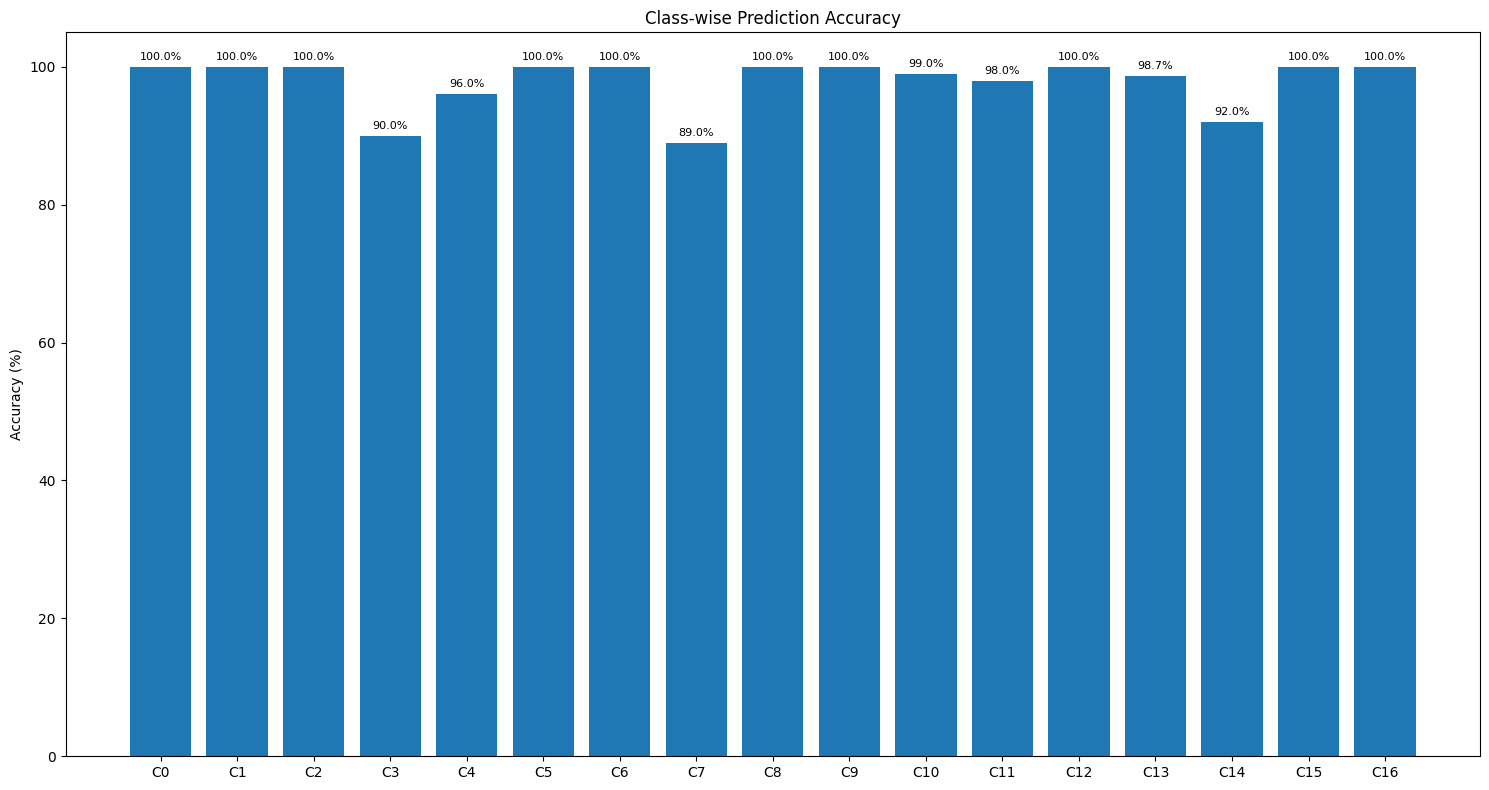

Worst 3 classes:
Class 7: 89.0%
Class 3: 90.0%
Class 14: 92.0%


In [12]:
# 클래스별 성능 시각화
meta_df = pd.read_csv("../data/meta.csv")
avg_acc = {c: np.mean([f.get(c,0) for f in fold_class_accuracies]) for c in range(17)}

plt.figure(figsize=(15, 8))
classes = list(avg_acc.keys())
accs = [avg_acc[c] * 100 for c in classes]
names = [f"C{c}" for c in classes]

plt.bar(range(17), accs)
plt.xticks(range(17), names)
plt.ylabel('Accuracy (%)')
plt.title('Class-wise Prediction Accuracy')
for i, acc in enumerate(accs):
    plt.text(i, acc + 1, f'{acc:.1f}%', ha='center', fontsize=8)
plt.tight_layout()
plt.show()

print("Worst 3 classes:")
worst = sorted(avg_acc.items(), key=lambda x: x[1])[:3]
for c, acc in worst:
    print(f"Class {c}: {acc*100:.1f}%")

In [22]:
# 긴급 모델 저장 - 현재 상태 그대로 저장
def save_models():
    """학습한 모델들을 저장"""
    
    # 저장 디렉토리 생성
    save_dir = "models"
    os.makedirs(save_dir, exist_ok=True)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    print("🚨 모델 저장 시작...")
    
    # 각 fold별 모델 저장 (fold_models 리스트가 있다고 가정)
    try:
        for fold in range(5):  # 5-fold라고 가정
            model_path = f"{save_dir}/fold_{fold}_model_{timestamp}.pth"
            
            # fold_models[fold]가 존재한다면 저장
            if 'fold_models' in globals() and len(fold_models) > fold:
                torch.save({
                    'model_state_dict': fold_models[fold].state_dict(),
                    'fold': fold,
                    'timestamp': timestamp,
                    'epoch': 'unknown',  # 에포크 정보 모르면 unknown
                }, model_path)
                print(f"✅ Fold {fold} 모델 저장 완료: {model_path}")
            
            # 또는 best_models 리스트가 있다면
            elif 'best_models' in globals() and len(best_models) > fold:
                torch.save({
                    'model_state_dict': best_models[fold].state_dict(),
                    'fold': fold,
                    'timestamp': timestamp,
                    'epoch': 'unknown',
                }, model_path)
                print(f"✅ Fold {fold} best 모델 저장 완료: {model_path}")
                
    except Exception as e:
        print(f"❌ Fold별 저장 실패: {e}")
    
    # 전체 변수 상태 저장 (혹시 모르니까)
    try:
        state_path = f"{save_dir}/full_state_{timestamp}.pth"
        
        # 현재 글로벌 변수에서 모델 관련 객체들 찾아서 저장
        save_dict = {}
        
        # 가능한 모델 변수명들 체크
        possible_model_vars = ['model', 'models', 'fold_models', 'best_models', 
                              'tta_models', 'ensemble_models']
        
        for var_name in possible_model_vars:
            if var_name in globals():
                save_dict[var_name] = globals()[var_name]
                print(f"✅ {var_name} 변수 포함됨")
        
        if save_dict:
            torch.save(save_dict, state_path)
            print(f"✅ 전체 상태 저장 완료: {state_path}")
        
    except Exception as e:
        print(f"❌ 전체 상태 저장 실패: {e}")
    
    print(f"🎉 저장 완료! 저장 위치: {save_dir}/")
    print(f"📁 파일 목록:")
    for file in os.listdir(save_dir):
        print(f"   - {file}")

In [23]:
emergency_save_models()

🚨 긴급 모델 저장 시작...
❌ Fold별 저장 실패: 'collections.OrderedDict' object has no attribute 'state_dict'
✅ model 변수 포함됨
✅ fold_models 변수 포함됨
✅ ensemble_models 변수 포함됨
✅ 전체 상태 저장 완료: emergency_models/full_state_20250907_092200.pth
🎉 긴급 저장 완료! 저장 위치: emergency_models/
📁 파일 목록:
   - full_state_20250907_091916.pth
   - full_state_20250907_092200.pth


In [ ]:
# # 저장된 모델 다시 불러오기
# saved_state = torch.load("emergency_models/full_state_20250907_091916.pth")

# fold_models = saved_state['fold_models']
# ensemble_models = saved_state['ensemble_models']
# model = saved_state['model']

🔍 현재 GPU 메모리: 8.34 GB
🔍 예약된 메모리: 12.65 GB


In [71]:
# 5-Fold 앙상블 모델 준비
ensemble_models = []
for i, state_dict in enumerate(fold_models):
    fold_model = timm.create_model(model_name, pretrained=True, num_classes=17).to(device)
    fold_model.load_state_dict(state_dict)
    fold_model.eval()
    ensemble_models.append(fold_model)
print(f"Using ensemble of all {len(ensemble_models)} fold models for inference")

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 23.69 GiB of which 13.88 MiB is free. Process 660397 has 5.71 GiB memory in use. Process 2320209 has 17.91 GiB memory in use. Of the allocated memory 16.55 GiB is allocated by PyTorch, and 1.02 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [ ]:
# Temperature Scaling 클래스 정의
class TemperatureScaling(nn.Module):
    def __init__(self):
        super().__init__()
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)
    
    def forward(self, logits):
        return logits / self.temperature

In [ ]:
# # 기존 변수들 정리 (모델 제외)
# if 'tta_loader' in globals():
#     del tta_loader
# if 'essential_tta_transforms' in globals():
#     del essential_tta_transforms
    
# # GPU 메모리 정리
# torch.cuda.empty_cache()
# gc.collect()

# print(f"🔍 현재 GPU 메모리: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
# print(f"🔍 예약된 메모리: {torch.cuda.memory_reserved()/1024**3:.2f} GB")

🔍 현재 GPU 메모리: 8.34 GB
🔍 예약된 메모리: 12.65 GB


In [75]:
essential_tta_transforms = [
    # 원본
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    # 90도 회전들
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[90, 90], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[180, 180], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[-90, -90], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    # 밝기 개선
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.RandomBrightnessContrast(brightness_limit=[0.3, 0.3], contrast_limit=[0.3, 0.3], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
]

In [76]:
# TTA 추론을 위한 Dataset 클래스
class TTAImageDataset(Dataset):
    def __init__(self, data, path, transforms):
        if isinstance(data, str):
            self.df = pd.read_csv(data).values
        else:
            self.df = data.values
        self.path = path
        self.transforms = transforms  # 여러 transform을 리스트로 받음

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)).convert('RGB'))
        
        # 모든 transform을 적용한 결과를 리스트로 반환
        augmented_images = []
        for transform in self.transforms:
            aug_img = transform(image=img)['image']
            augmented_images.append(aug_img)
        
        return augmented_images, target

In [77]:
# TTA Dataset 생성
tta_dataset = TTAImageDataset(
    "../data/sample_submission.csv",
    "../data/test/",
    essential_tta_transforms
)

# TTA DataLoader (배치 크기를 줄여서 메모리 절약)
tta_loader = DataLoader(
    tta_dataset,
    batch_size=16,  # TTA는 메모리를 많이 사용하므로 배치 크기 줄임
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

print(f"TTA Dataset size: {len(tta_dataset)}")

TTA Dataset size: 3140


In [78]:
def ensemble_tta_inference(models, loader, transforms, confidence_threshold=0.9):
    """5-Fold 모델 앙상블 + TTA 추론"""
    all_predictions = []
    
    for batch_idx, (images_list, _) in enumerate(tqdm(loader, desc="Ensemble TTA")):
        batch_size = images_list[0].size(0)
        ensemble_probs = torch.zeros(batch_size, 17).to(device)
        
        # 각 fold 모델별 예측
        for model in models:
            with torch.no_grad():
                # 각 TTA 변형별 예측
                for images in images_list:
                    images = images.to(device)
                    preds = model(images)
                    probs = torch.softmax(preds, dim=1)
                    ensemble_probs += probs / (len(models) * len(images_list))
        
        final_preds = torch.argmax(ensemble_probs, dim=1)
        all_predictions.extend(final_preds.cpu().numpy())
    
    return all_predictions

In [79]:
# 앙상블 TTA 실행
print("Starting Ensemble TTA inference...")
tta_predictions = ensemble_tta_inference(
    models=ensemble_models, 
    loader=tta_loader, 
    transforms=essential_tta_transforms,
    confidence_threshold=0.9
)

Starting Ensemble TTA inference...


Ensemble TTA: 100%|██████████| 197/197 [13:02<00:00,  3.97s/it]


In [80]:
# TTA 결과로 submission 파일 생성
tta_pred_df = pd.DataFrame(tta_dataset.df, columns=['ID', 'target'])
tta_pred_df['target'] = tta_predictions

In [81]:
# 기존 submission과 동일한 순서인지 확인
sample_submission_df = pd.read_csv("../data/sample_submission.csv")
assert (sample_submission_df['ID'] == tta_pred_df['ID']).all()

In [82]:
# TTA 결과 저장
tta_pred_df.to_csv("../submission/choice.csv", index=False)
print("TTA predictions saved")

print("TTA Prediction sample:")

TTA predictions saved
TTA Prediction sample:


In [83]:
tta_pred_df.head()

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,12
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,12
4,00901f504008d884.jpg,2
